In [1]:
import torch
import torch.distributions as D
import torch.nn as nn
import numpy as np
import copy
from optimal_transport import OTPlanSampler

from IPython.display import display, HTML

from matplotlib import pyplot as plt
from matplotlib import animation
import scipy.optimize as opt
from scipy.stats import entropy
from numpy.linalg import norm
import seaborn as sns
import copy

/net/pulsar/home/koes/rishal/.conda/envs/torsional/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Initial and final distributions

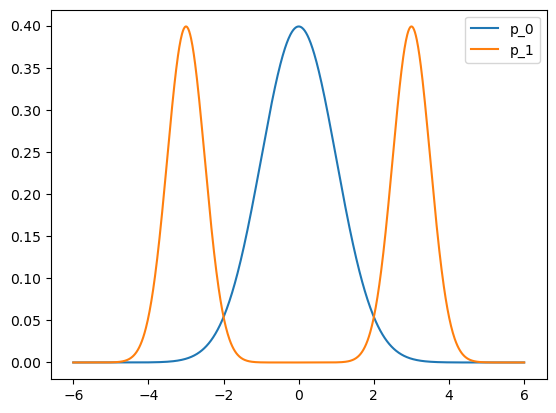

In [3]:
def build_gmm(n_modes, means=None, vars=None):

    if means is None:
        means = torch.randn(n_modes,1)
    if vars is None:
        vars = torch.rand(n_modes,1)
        vars[:,1] = vars[:,0]

    mix = D.Categorical(torch.ones(n_modes,))
    comp = D.Independent(D.Normal(means, vars), 1)
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm


p_0_means = torch.zeros(1)
p_0_vars = torch.ones(1)
p_0 = D.Normal(p_0_means, p_0_vars)


p_1_means = torch.tensor([[3], [ -3]]).float()
p_1_vars = torch.ones(2,1)*0.5
p_1 = build_gmm(2, p_1_means, p_1_vars)

x=np.linspace(-6,6,1000)
plt.plot(x, p_0.log_prob(torch.tensor(x)).exp(), label='p_0')
plt.plot(x, p_1.log_prob(torch.tensor(x).unsqueeze(1)).exp(), label='p_1')
# plt.gca().set_aspect('equal', adjustable='box')
# xlim = plt.gca().get_xlim()
# ylim = plt.gca().get_ylim()
plt.legend()
plt.show()

## Train flow matching model

In [4]:
u = nn.Sequential(
        nn.Linear(2, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 15),
        nn.ReLU(),
        nn.Linear(15, 1)
    )

Iteration 0, loss = 0.04
Final loss = 0.04


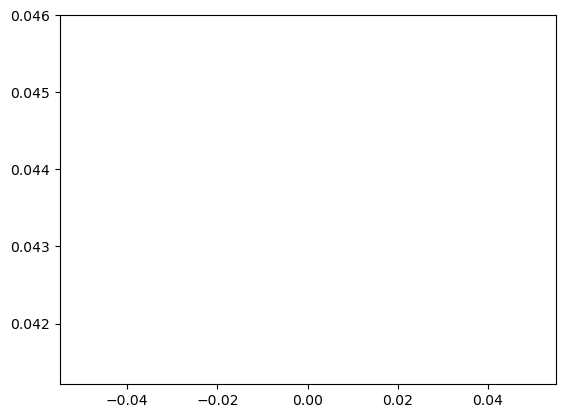

In [25]:
def train_flow_matching_model(u,n_iterations, batch_size, p_0, p_1, learning_rate=1.0e-4, sigma=0.1, use_ot=False,model_weights=None):
    
    if model_weights is not None:
        u.load_state_dict(torch.load(model_weights))

    # intitalize adam optimizer
    optimizer = torch.optim.Adam(u.parameters(), lr=learning_rate)

    if use_ot:
        ot_sampler = OTPlanSampler()

    losses = []

    for iter_idx in range(n_iterations):

        # zero out gradients
        optimizer.zero_grad()

        x_0 = p_0.sample((batch_size,))
        x_1 = p_1.sample((batch_size,))

        if use_ot:
            x_0, x_1 = ot_sampler.sample_plan(x_0, x_1)

        # sample time
        t = torch.rand(batch_size,)

        # construct x_t
        mu_x_t = x_0 + t[:,None]*(x_1 - x_0)
        # sigma_x_t = sigma*torch.ones_like(mu_x_t)
        # x_t = mu_x_t + sigma_x_t*torch.randn_like(mu_x_t)
        x_t  = mu_x_t

        # compute true conditional vectors
        u_true = x_1 - x_0

        # predict conditional vectors
        u_pred = u(torch.cat((x_t, t[:,None]), dim=-1))

        # compute loss
        loss = torch.square(u_true - u_pred).sum(dim=1).mean()

        # compute gradients
        loss.backward()

        # update parameters
        optimizer.step()


        losses.append(loss.item())
        if iter_idx % 100 == 0:
            print(f'Iteration {iter_idx}, loss = {loss.item():.2f}')
            #save model weights
            torch.save(u.state_dict(), 'model_weights.pth')
    
    return losses, u

losses, u = train_flow_matching_model(u=u,n_iterations=int(1), batch_size=32, p_0=p_0, p_1=p_1, learning_rate=1.0e-4, sigma=0.001, use_ot=True,model_weights='model_weights.pth')

# print the average loss in the last 100 iterations
print(f'Final loss = {np.mean(losses[-100:]):.2f}')

plt.plot(losses)
plt.show()

Integrate vector field

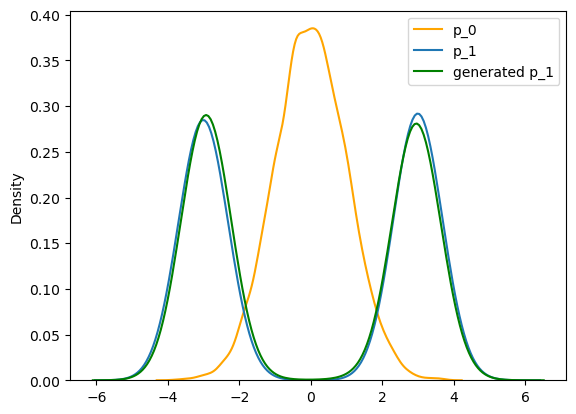

In [10]:
@torch.no_grad()
def integrate_u(x_0, u, n_steps=20):
    """Use Euler integration to integrate the time-varying vector field u from 0 to 1"""

    # x_0 is a tensor of shape (batch_size, 2) containing the initial positions
    # u is a time varying vector field (the trained neural network)
    # n_steps is the number of integration steps to run
    batch_size = x_0.shape[0]
    t = torch.linspace(0, 1, n_steps).cuda()
    dt = t[1] - t[0]
    x_t = torch.zeros(*x_0.shape, n_steps, dtype=x_0.dtype).cuda() # state, has shape (batch_size, 2, n_steps)
    x_t[:,:,0] = x_0
    for step_idx in range(n_steps-1):
        current_state = x_t[:, :, step_idx].cuda()
        u_input = torch.cat((current_state, t[step_idx]*torch.ones(batch_size, 1).cuda()), dim=-1)
        x_t[:, :, step_idx+1] = current_state + dt*u(u_input)
    return t, x_t

# def make_density_plot(dist, xlim, ylim, n_points=100, cmap='Reds', alpha=0.75):
#     # plot p_0 and p_1 densities on a mesh grid
#     x = torch.linspace(*xlim, n_points)
#     y = torch.linspace(*ylim, n_points)
#     X, Y = torch.meshgrid(x, y)
#     grid = torch.stack((X.flatten(), Y.flatten()), dim=-1)
#     density = torch.exp(dist.log_prob(grid)).reshape(n_points,n_points)
#     plt.pcolormesh(X, Y, density, cmap=cmap, alpha=alpha)


# make_density_plot(dist=p_0, xlim=xlim, ylim=ylim, cmap='Reds', alpha=0.5)
# make_density_plot(dist=p_1, xlim=xlim, ylim=ylim, cmap='Blues', alpha=0.5)
u.load_state_dict(torch.load('model_weights.pth'))
u=u.cuda()
n_trajectories = 10000
x_0 = p_0.sample((n_trajectories,)).cuda()
t, x_t = integrate_u(x_0, u, n_steps=20)
t=t.detach().cpu().numpy()
x_t=x_t.detach().cpu().numpy()

# for traj_idx in range(n_trajectories):
#     plt.plot(x_t[traj_idx,0,:], x_t[traj_idx,1,:], alpha=0.2 , lw=3, color='gray')

    
# plt.gca().set_aspect('equal', )
samples_0 = p_0.sample((10000,))



samples_1 = p_1.sample((10000,))
sns.kdeplot(samples_0[:, 0], label='p_0',color='orange')
sns.kdeplot(samples_1, label='p_1',color='red')
sns.kdeplot(x_t[:,0,-1], label='generated p_1',color='green')
# plt.gca().set_aspect('equal', adjustable='box')
# xlim = plt.gca().get_xlim()
# ylim = plt.gca().get_ylim()
plt.legend()
plt.show()


## NCE across the 20 timepoints

In [6]:
#nce value function

def value(energy, noise, x, gen,exponential=False):
    logp_x = energy(x)  # logp(x)
    try:
        logq_x = noise.log_prob(x)  # logq(x)
    except:
        logq_x = noise.log_prob(x.clone().detach().cpu()).cuda()
    logp_gen = energy(gen)  # logp(x̃)
    try:
        logq_gen = noise.log_prob(gen)  # logq(x̃)
    except:
        logq_gen = noise.log_prob(gen.clone().detach().cpu()).cuda()
    if not exponential:    
        value_data = logp_x - torch.logsumexp(torch.cat([logp_x, logq_x], dim=1), dim=1, keepdim=True)  # log[p(x)/(p(x) + q(x))]
        value_gen = logq_gen - torch.logsumexp(torch.cat([logp_gen, logq_gen], dim=1), dim=1, keepdim=True)  # log[q(x̃)/(p(x̃) + q(x̃))]
    else:
        value_data = -torch.exp(-(0.5*logp_x - 0.5*logq_x))
        value_gen = -torch.exp(0.5*logp_gen - 0.5*logq_gen)

    v = value_data.mean() + value_gen.mean()

    r_x = torch.sigmoid(logp_x - logq_x)
    r_gen = torch.sigmoid(logq_gen - logp_gen)

    acc = ((r_x > 1/2).sum() + (r_gen > 1/2).sum()).cpu().numpy() / (len(x) + len(gen))

    return -v,  acc

In [7]:
#define neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1=nn.Linear(1, 100)
        self.fc2=nn.Linear(100, 100)
        self.fc3=nn.Linear(100, 1)
        self.partition=nn.Parameter(torch.tensor([1.], requires_grad=True))
    
    def forward(self, x):
        x=torch.relu(self.fc1(x))
        x=torch.relu(self.fc2(x))
        x=self.fc3(x)
        return - x - torch.log(self.partition)
    
    def log_prob(self, x):
        return self.forward(x)

In [8]:
def bar_function(x,diff_1,diff_2):
    term_1=np.sum(1/(1+np.exp(diff_1 - x)))
    term_2=np.sum(1/(1+np.exp(diff_2 + x)))
    return (term_1-term_2)**2

In [8]:
def kl_divergence(prev_probs,current_probs):
    log_ratio=torch.log(prev_probs/(current_probs + 1e-10))
    return torch.sum(prev_probs*log_ratio)
    

In [9]:
def jensen_shanon_div(P,Q):
    P=P.cpu().numpy()
    Q=Q.cpu().numpy()
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return np.abs(0.5 * (entropy(_P, _M) + entropy(_Q, _M)))

In [11]:
def langevin_mala(model,data,num_steps=1000,step_size=0.1):
    for i in range(num_steps):
        data.requires_grad_(True)
        data.retain_grad()
        model.zero_grad()
        logp_x=model.log_prob(data)
        logp_x.sum().backward()
        with torch.no_grad():
            data_mean=data+step_size*data.grad
            data_new=data_mean + np.sqrt(2*step_size)*torch.randn_like(data)
        model.zero_grad()
        data_new.requires_grad_(True)
        data_new.retain_grad()
        logp_x_new=model.log_prob(data_new)
        logp_x_new.sum().backward()
        with torch.no_grad():
            data_new_mean=data_new+step_size*data_new.grad
            probability_ratio=torch.exp(logp_x_new-logp_x)
            transition_ratio=torch.exp(-torch.norm(data-data_new_mean,dim=1)**2/(4*step_size)+torch.norm(data_new-data_mean,dim=1)**2/(4*step_size)).unsqueeze(1)
            acceptance_ratio=torch.min(torch.ones_like(probability_ratio),probability_ratio*transition_ratio)
            u=torch.rand_like(acceptance_ratio)
            data=data_new*(u<acceptance_ratio).float()+data*(u>=acceptance_ratio).float()
    return data

In [12]:
u.load_state_dict(torch.load('model_weights.pth'))
u=u.cuda()

In [13]:
def train_iteration(u,training_iterations,batch_size,prev_dist,timepoint,lr=1e-4,exponential=False,normalize_grad=False,base_dist=None,p_0=p_0,p_1=p_1,mala=False):
    if base_dist is None:
        model=Net().cuda()
    else:
        model=copy.deepcopy(base_dist)
    T=timepoint
    optimizer=torch.optim.Adam(model.parameters(), lr=lr)
    prev_probs=(1/10000 * torch.ones((batch_size,1))).cuda()
    min_js=10
    counter=1
    for i in range(training_iterations):
        optimizer.zero_grad()
        x_0 = p_0.sample((batch_size,)).cuda()
        t, x_t = integrate_u(x_0, u, n_steps=20)
        if T!=19:
            x_batch=x_t[:,:,T+1].cuda()
        else:
            x_batch=p_1.sample((batch_size,)).cuda()
        if i%100==0:
            if mala:
                base_dist=copy.deepcopy(model)
                mala_data=langevin_mala(base_dist,x_batch,num_steps=1000,step_size=0.1)
        loss, acc=value(model, prev_dist, x_batch, x_t[:,:,T].cuda(),exponential=exponential)
        if mala:
            loss2, acc2=value(model, base_dist, x_batch, mala_data,exponential=exponential)
        # if next_dist is not None: 
        #     if T<=17:
        #         loss2, acc2=value(model, next_dist, x_batch, x_t[:,:,T+2].cuda(),exponential=exponential)
        #     elif T!=19:
        #         loss2, acc2=value(model, next_dist, x_batch, p_1.sample((batch_size,)).cuda(),exponential=exponential)
            loss=(loss+loss2)/2
            acc=(acc+acc2)/2
        loss.backward()
        if normalize_grad:
            for p in model.parameters():
                p.grad /= (torch.norm(p.grad) + 1e-10)
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        if i%100==0:
            with torch.no_grad():
                if i!=0:
                    prev_probs=torch.exp(prev_model(x_batch))
                current_probs=torch.exp(model(x_batch))
                kl_div=kl_divergence(prev_probs,current_probs)
                js_div=jensen_shanon_div(prev_probs,current_probs)
                if js_div<min_js:
                    min_js=js_div
                    counter=1
                else:
                    counter+=1
                mse=torch.mean((current_probs-prev_probs)**2)
                prev_model=copy.deepcopy(model)
                print('Time: ', T,'iteration: ', i,'loss: ', loss.item(), 'acc: ', acc, 'kl_div: ',kl_div,'mse: ',mse,'js_div: ',js_div)                
        if counter>=20:
                optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']/10
                counter=1
                if optimizer.param_groups[0]['lr']<1e-6:
                    break
    return model,x_batch

In [14]:
def plot_model(model,p_0,p_1,T):
    model.cuda()
    x=np.linspace(-6, 6, 1000)
    x=torch.Tensor(x).cuda().unsqueeze(1)
    initial_energy=p_0.log_prob(x.detach().cpu()).squeeze().numpy()
    true_energy=p_1.log_prob(x.detach().cpu()).squeeze().numpy()
    energy=model(x).detach().cpu().squeeze().numpy()
    x=x.cpu().squeeze().numpy()
    plt.plot(x, np.exp(initial_energy), label='p0')
    plt.plot(x, np.exp(true_energy), label='p1')
    plt.plot(x, np.exp(energy),label='model_p1_'+str(T+1))
    plt.legend()
    plt.show()

In [15]:

def train(u,training_iterations,batch_size=10000,lr=1e-4,bar=False,exponential=False,normalize_grad=False,p_0=p_0,p_1=p_1,mala=False):
    prev_dist=p_0
    for T in range(20):
        if T!=0:
            prev_dist=prev_dist.eval()
        model,x_batch=train_iteration(u,training_iterations,batch_size,prev_dist,T,lr=lr,exponential=exponential,normalize_grad=normalize_grad,p_0=p_0,p_1=p_1)
        # optimizer=torch.optim.Adam(model.parameters(), lr=lr)
        # training_iterations=training_iterations
        # batch_size=batch_size
        # prev_probs=(1/10000 * torch.ones((batch_size,1))).cuda()
        # min_js=10
        # counter=1
        # for i in range(training_iterations):
        #     optimizer.zero_grad()
        #     x_0 = p_0.sample((batch_size,)).cuda()
        #     t, x_t = integrate_u(x_0, u, n_steps=20)
        #     if T!=19:
        #         x_batch=x_t[:,:,T+1].cuda()
        #     else:
        #         x_batch=p_1.sample((batch_size,)).cuda()
        #     loss, acc=value(model, prev_dist, x_batch, x_t[:,:,T].cuda(),exponential=exponential)
        #     loss.backward()
        #     if normalize_grad:
        #         for p in model.parameters():
        #             p.grad /= (torch.norm(p.grad) + 1e-10)
        #     nn.utils.clip_grad_norm_(model.parameters(), 1)
        #     optimizer.step()
        #     if i%100==0:
        #         with torch.no_grad():
        #             if i!=0:
        #                 prev_probs=torch.exp(prev_model(x_batch))
        #             current_probs=torch.exp(model(x_batch))
        #             kl_div=kl_divergence(prev_probs,current_probs)
        #             js_div=jensen_shanon_div(prev_probs,current_probs)
        #             if js_div<min_js:
        #                 min_js=js_div
        #                 counter=1
        #             else:
        #                 counter+=1
        #             mse=torch.mean((current_probs-prev_probs)**2)
        #             prev_model=copy.deepcopy(model)
        #             print('Time: ', T,'iteration: ', i,'loss: ', loss.item(), 'acc: ', acc, 'kl_div: ',kl_div,'mse: ',mse,'js_div: ',js_div)
        #     if counter>=20:
        #         optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']/10
        #         counter=1
        #         if optimizer.param_groups[0]['lr']<1e-6:
        #             break
        if bar:
            if T!=0:
                x_t_prev_energy=(prev_dist.log_prob(x_t[:,:,T].cuda())+torch.log(prev_dist.partition)).detach().cpu().numpy()
            else:
                x_t_prev_energy=prev_dist.log_prob(x_t[:,:,T].clone().detach().cpu()).numpy()
            x_t_curr_energy=(model(x_t[:,:,T])+torch.log(model.partition)).detach().cpu().numpy()
            diff_1=-x_t_prev_energy+x_t_curr_energy
            if T!=0:
                x_batch_prev_energy=(prev_dist.log_prob(x_batch)+torch.log(prev_dist.partition)).detach().cpu().numpy()
            else:
                x_batch_prev_energy=prev_dist.log_prob(x_batch.clone().detach().cpu()).numpy()
            x_batch_curr_energy=(model(x_batch)+torch.log(model.partition)).detach().cpu().numpy()
            diff_2 = x_batch_prev_energy-x_batch_curr_energy
            if T!=0:
                initial_guess=prev_dist.partition.clone().detach().cpu().numpy() - model.partition.clone().detach().cpu().numpy()
            else:
                initial_guess=model.partition.clone().detach().cpu().numpy()
            free_energy=opt.basinhopping(bar_function,initial_guess,minimizer_kwargs={"args": (diff_1,diff_2,)},niter=1000)
            if T!=0:
                model.partition = nn.Parameter(torch.tensor([torch.exp(torch.log(prev_dist.partition) + torch.tensor([free_energy.x]).cuda())], requires_grad=True,device="cuda"))
            else:
                model.partition = nn.Parameter(torch.tensor([torch.exp(torch.tensor([free_energy.x]))], requires_grad=True,device="cuda"))
        plot_model(model,p_0,p_1,T)
        if mala:
            base_model=copy.deepcopy(model)
            base_model.cuda().eval()
            model,x_batch=train_iteration(u,training_iterations,batch_size,prev_dist,T,lr=lr,exponential=exponential,normalize_grad=normalize_grad,base_dist=base_model,p_0=p_0,p_1=p_1,mala=mala)
            plot_model(model,p_0,p_1,T)
        prev_dist=copy.deepcopy(model)
        print('T: ', T)
    return model
    
        

In [20]:
model = train(u,30000,lr=1e-4)

Time:  0 iteration:  0 loss:  1.9720256328582764 acc:  0.5 kl_div:  tensor(-9.3240, device='cuda:0') mse:  tensor(1.2658, device='cuda:0') js_div:  [0.00052169]


KeyboardInterrupt: 

# train with refinement

Time:  0 iteration:  0 loss:  1.8862758874893188 acc:  0.5 kl_div:  tensor(-9.1987, device='cuda:0') mse:  tensor(0.9931, device='cuda:0') js_div:  [0.00102771]
Time:  0 iteration:  100 loss:  1.426090955734253 acc:  0.5068 kl_div:  tensor(11833.2373, device='cuda:0') mse:  tensor(0.4650, device='cuda:0') js_div:  [0.01256987]
Time:  0 iteration:  200 loss:  1.3929646015167236 acc:  0.5243 kl_div:  tensor(942.5912, device='cuda:0') mse:  tensor(0.0079, device='cuda:0') js_div:  [0.00393015]
Time:  0 iteration:  300 loss:  1.3883633613586426 acc:  0.5213 kl_div:  tensor(-44.1960, device='cuda:0') mse:  tensor(7.0089e-05, device='cuda:0') js_div:  [0.00012625]
Time:  0 iteration:  400 loss:  1.3853282928466797 acc:  0.5231 kl_div:  tensor(-41.1925, device='cuda:0') mse:  tensor(3.8871e-05, device='cuda:0') js_div:  [5.3183285e-05]
Time:  0 iteration:  500 loss:  1.3841466903686523 acc:  0.52935 kl_div:  tensor(-15.0653, device='cuda:0') mse:  tensor(1.6039e-05, device='cuda:0') js_div:  

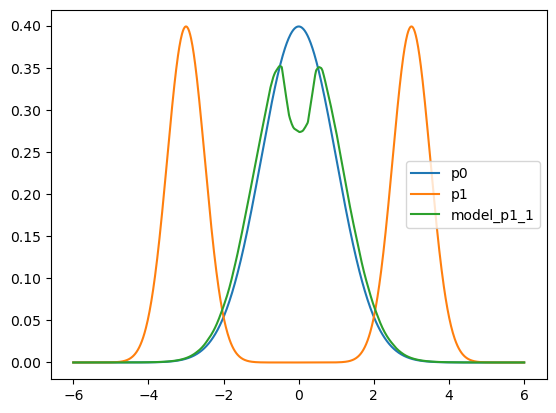

Time:  0 iteration:  0 loss:  1.381629228591919 acc:  0.27035 kl_div:  tensor(-7.7033, device='cuda:0') mse:  tensor(0.0716, device='cuda:0') js_div:  [0.02299981]
Time:  0 iteration:  100 loss:  1.3815569877624512 acc:  0.26965 kl_div:  tensor(-57.2521, device='cuda:0') mse:  tensor(4.6117e-05, device='cuda:0') js_div:  [1.0191126e-05]
Time:  0 iteration:  200 loss:  1.381673812866211 acc:  0.26975 kl_div:  tensor(20.1444, device='cuda:0') mse:  tensor(1.7852e-05, device='cuda:0') js_div:  [2.704161e-05]
Time:  0 iteration:  300 loss:  1.3815486431121826 acc:  0.269 kl_div:  tensor(1.4132, device='cuda:0') mse:  tensor(2.1252e-05, device='cuda:0') js_div:  [3.4115394e-05]
Time:  0 iteration:  400 loss:  1.381683111190796 acc:  0.270875 kl_div:  tensor(-0.0627, device='cuda:0') mse:  tensor(2.9023e-05, device='cuda:0') js_div:  [5.395731e-05]
Time:  0 iteration:  500 loss:  1.3816933631896973 acc:  0.269575 kl_div:  tensor(7.8462, device='cuda:0') mse:  tensor(5.5117e-05, device='cuda:

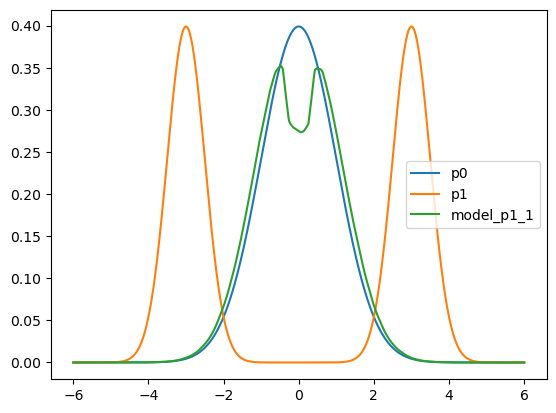

T:  0
Time:  1 iteration:  0 loss:  1.986892819404602 acc:  0.5 kl_div:  tensor(-9.3010, device='cuda:0') mse:  tensor(1.2092, device='cuda:0') js_div:  [0.00054954]
Time:  1 iteration:  100 loss:  1.5475282669067383 acc:  0.5 kl_div:  tensor(9768.8770, device='cuda:0') mse:  tensor(0.4155, device='cuda:0') js_div:  [0.00665804]
Time:  1 iteration:  200 loss:  1.407261610031128 acc:  0.49185 kl_div:  tensor(3324.1440, device='cuda:0') mse:  tensor(0.0561, device='cuda:0') js_div:  [0.00331211]
Time:  1 iteration:  300 loss:  1.4027702808380127 acc:  0.4894 kl_div:  tensor(23.1576, device='cuda:0') mse:  tensor(5.6296e-05, device='cuda:0') js_div:  [0.00014262]
Time:  1 iteration:  400 loss:  1.39811372756958 acc:  0.49295 kl_div:  tensor(-7.9949, device='cuda:0') mse:  tensor(1.0885e-05, device='cuda:0') js_div:  [3.0447382e-05]
Time:  1 iteration:  500 loss:  1.3965983390808105 acc:  0.4963 kl_div:  tensor(-8.4154, device='cuda:0') mse:  tensor(1.3821e-05, device='cuda:0') js_div:  [3

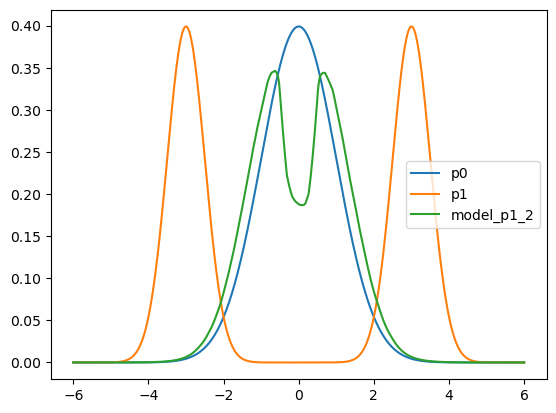

Time:  1 iteration:  0 loss:  1.3814539909362793 acc:  0.270475 kl_div:  tensor(-7.6812, device='cuda:0') mse:  tensor(0.0673, device='cuda:0') js_div:  [0.02212952]
Time:  1 iteration:  100 loss:  1.381359577178955 acc:  0.26995 kl_div:  tensor(20.0731, device='cuda:0') mse:  tensor(1.0241e-05, device='cuda:0') js_div:  [1.02614595e-05]
Time:  1 iteration:  200 loss:  1.3813121318817139 acc:  0.27045 kl_div:  tensor(-12.4016, device='cuda:0') mse:  tensor(1.1261e-05, device='cuda:0') js_div:  [2.0460868e-05]
Time:  1 iteration:  300 loss:  1.3817439079284668 acc:  0.270575 kl_div:  tensor(-0.7289, device='cuda:0') mse:  tensor(1.1441e-05, device='cuda:0') js_div:  [2.6486921e-05]
Time:  1 iteration:  400 loss:  1.3814868927001953 acc:  0.269475 kl_div:  tensor(8.2545, device='cuda:0') mse:  tensor(7.8356e-06, device='cuda:0') js_div:  [1.7204176e-05]
Time:  1 iteration:  500 loss:  1.381382942199707 acc:  0.270825 kl_div:  tensor(-9.8946, device='cuda:0') mse:  tensor(9.3508e-06, devi

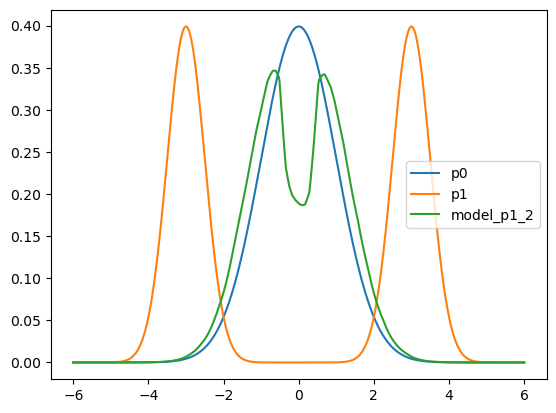

T:  1
Time:  2 iteration:  0 loss:  1.9382737874984741 acc:  0.5 kl_div:  tensor(-9.1631, device='cuda:0') mse:  tensor(0.9237, device='cuda:0') js_div:  [0.00096568]
Time:  2 iteration:  100 loss:  1.4607796669006348 acc:  0.4925 kl_div:  tensor(12105.4365, device='cuda:0') mse:  tensor(0.4595, device='cuda:0') js_div:  [0.02293148]
Time:  2 iteration:  200 loss:  1.4239168167114258 acc:  0.48475 kl_div:  tensor(863.0250, device='cuda:0') mse:  tensor(0.0075, device='cuda:0') js_div:  [0.00396423]
Time:  2 iteration:  300 loss:  1.420959711074829 acc:  0.48485 kl_div:  tensor(51.9377, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.0001567]
Time:  2 iteration:  400 loss:  1.415865182876587 acc:  0.48515 kl_div:  tensor(27.6416, device='cuda:0') mse:  tensor(7.3124e-05, device='cuda:0') js_div:  [0.00012865]
Time:  2 iteration:  500 loss:  1.4083383083343506 acc:  0.49105 kl_div:  tensor(11.8207, device='cuda:0') mse:  tensor(7.2108e-05, device='cuda:0') js_div:  [0.

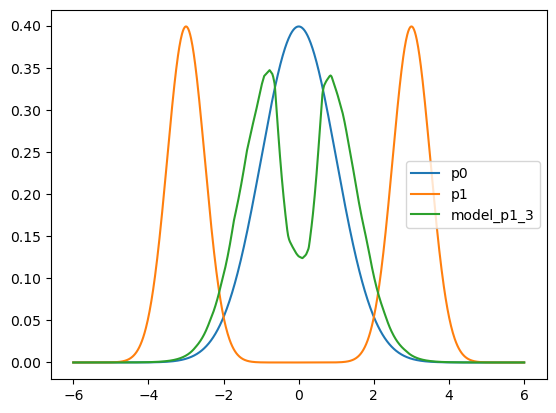

Time:  2 iteration:  0 loss:  1.381364107131958 acc:  0.27065 kl_div:  tensor(-7.6616, device='cuda:0') mse:  tensor(0.0665, device='cuda:0') js_div:  [0.02384806]
Time:  2 iteration:  100 loss:  1.3814003467559814 acc:  0.270675 kl_div:  tensor(32.0031, device='cuda:0') mse:  tensor(2.4672e-05, device='cuda:0') js_div:  [2.3365392e-05]
Time:  2 iteration:  200 loss:  1.3813960552215576 acc:  0.271425 kl_div:  tensor(-2.8354, device='cuda:0') mse:  tensor(1.0619e-05, device='cuda:0') js_div:  [2.5070069e-05]
Time:  2 iteration:  300 loss:  1.3813904523849487 acc:  0.270475 kl_div:  tensor(0.2230, device='cuda:0') mse:  tensor(1.2728e-05, device='cuda:0') js_div:  [2.8113078e-05]
Time:  2 iteration:  400 loss:  1.3814613819122314 acc:  0.271375 kl_div:  tensor(-16.7742, device='cuda:0') mse:  tensor(2.5808e-05, device='cuda:0') js_div:  [4.338678e-05]
Time:  2 iteration:  500 loss:  1.3811311721801758 acc:  0.271775 kl_div:  tensor(8.4365, device='cuda:0') mse:  tensor(5.4189e-06, devic

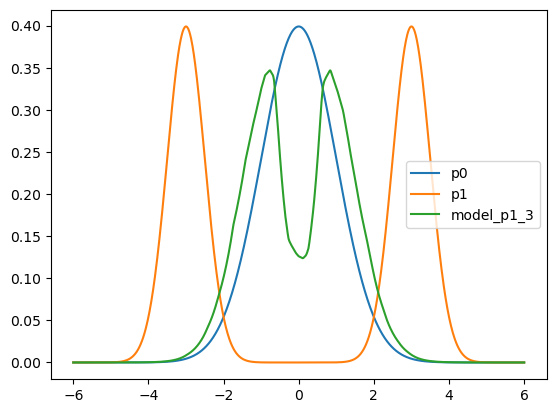

T:  2
Time:  3 iteration:  0 loss:  2.2108232975006104 acc:  0.5 kl_div:  tensor(-9.5432, device='cuda:0') mse:  tensor(1.9859, device='cuda:0') js_div:  [0.00124202]
Time:  3 iteration:  100 loss:  1.5167577266693115 acc:  0.5 kl_div:  tensor(19737.7617, device='cuda:0') mse:  tensor(1.1178, device='cuda:0') js_div:  [0.00959909]
Time:  3 iteration:  200 loss:  1.4399387836456299 acc:  0.4902 kl_div:  tensor(1856.3020, device='cuda:0') mse:  tensor(0.0228, device='cuda:0') js_div:  [0.00370868]
Time:  3 iteration:  300 loss:  1.4376494884490967 acc:  0.49205 kl_div:  tensor(20.9810, device='cuda:0') mse:  tensor(4.1129e-05, device='cuda:0') js_div:  [7.626317e-05]
Time:  3 iteration:  400 loss:  1.4318666458129883 acc:  0.49305 kl_div:  tensor(14.8918, device='cuda:0') mse:  tensor(3.0848e-05, device='cuda:0') js_div:  [6.629421e-05]
Time:  3 iteration:  500 loss:  1.4261887073516846 acc:  0.49275 kl_div:  tensor(1.5945, device='cuda:0') mse:  tensor(3.3159e-05, device='cuda:0') js_di

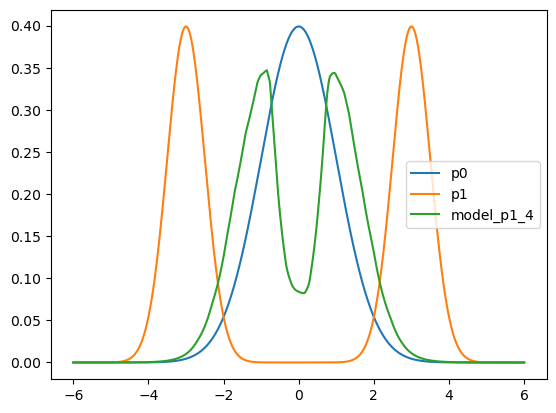

Time:  3 iteration:  0 loss:  1.3810462951660156 acc:  0.271125 kl_div:  tensor(-7.6160, device='cuda:0') mse:  tensor(0.0645, device='cuda:0') js_div:  [0.02781799]
Time:  3 iteration:  100 loss:  1.381307601928711 acc:  0.270575 kl_div:  tensor(-31.7068, device='cuda:0') mse:  tensor(2.0004e-05, device='cuda:0') js_div:  [1.940225e-05]
Time:  3 iteration:  200 loss:  1.3813378810882568 acc:  0.26905 kl_div:  tensor(4.7651, device='cuda:0') mse:  tensor(1.3118e-05, device='cuda:0') js_div:  [3.0147723e-05]
Time:  3 iteration:  300 loss:  1.381223201751709 acc:  0.27025 kl_div:  tensor(16.5634, device='cuda:0') mse:  tensor(1.2855e-05, device='cuda:0') js_div:  [1.7544693e-05]
Time:  3 iteration:  400 loss:  1.381303071975708 acc:  0.2706 kl_div:  tensor(-11.7184, device='cuda:0') mse:  tensor(1.8564e-05, device='cuda:0') js_div:  [3.7837002e-05]
Time:  3 iteration:  500 loss:  1.3813645839691162 acc:  0.27125 kl_div:  tensor(-5.5963, device='cuda:0') mse:  tensor(8.2530e-06, device='c

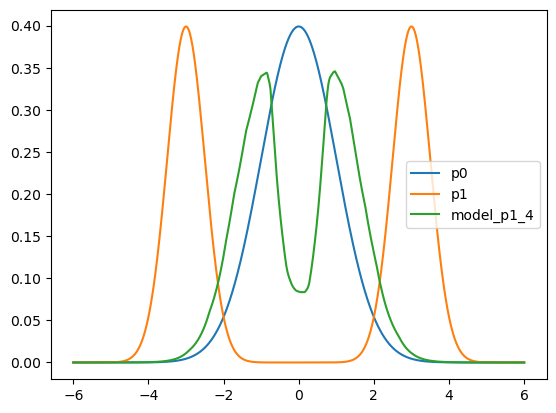

T:  3
Time:  4 iteration:  0 loss:  2.1413626670837402 acc:  0.5 kl_div:  tensor(-9.4181, device='cuda:0') mse:  tensor(1.5211, device='cuda:0') js_div:  [0.00025852]
Time:  4 iteration:  100 loss:  1.5682812929153442 acc:  0.5 kl_div:  tensor(14155.1406, device='cuda:0') mse:  tensor(0.6974, device='cuda:0') js_div:  [0.00919429]
Time:  4 iteration:  200 loss:  1.4594371318817139 acc:  0.4841 kl_div:  tensor(2525.8247, device='cuda:0') mse:  tensor(0.0360, device='cuda:0') js_div:  [0.00123374]
Time:  4 iteration:  300 loss:  1.4489821195602417 acc:  0.48795 kl_div:  tensor(39.0815, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00028898]
Time:  4 iteration:  400 loss:  1.4408838748931885 acc:  0.4934 kl_div:  tensor(35.3846, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.0002554]
Time:  4 iteration:  500 loss:  1.4330878257751465 acc:  0.4926 kl_div:  tensor(11.3510, device='cuda:0') mse:  tensor(8.9485e-05, device='cuda:0') js_div:  [0.0002150

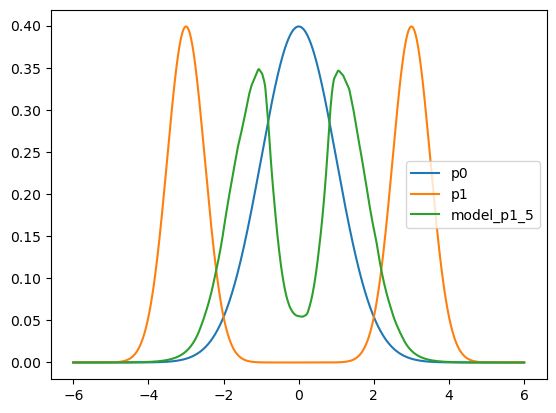

Time:  4 iteration:  0 loss:  1.3811490535736084 acc:  0.26995 kl_div:  tensor(-7.6292, device='cuda:0') mse:  tensor(0.0667, device='cuda:0') js_div:  [0.02846469]
Time:  4 iteration:  100 loss:  1.3810300827026367 acc:  0.2705 kl_div:  tensor(-5.9987, device='cuda:0') mse:  tensor(1.7941e-05, device='cuda:0') js_div:  [3.4414603e-05]
Time:  4 iteration:  200 loss:  1.3810327053070068 acc:  0.271225 kl_div:  tensor(12.5041, device='cuda:0') mse:  tensor(1.9398e-05, device='cuda:0') js_div:  [4.3341166e-05]
Time:  4 iteration:  300 loss:  1.381188154220581 acc:  0.270725 kl_div:  tensor(-22.2933, device='cuda:0') mse:  tensor(2.5545e-05, device='cuda:0') js_div:  [4.426148e-05]
Time:  4 iteration:  400 loss:  1.3813376426696777 acc:  0.271925 kl_div:  tensor(14.9423, device='cuda:0') mse:  tensor(3.0262e-05, device='cuda:0') js_div:  [5.2637828e-05]
Time:  4 iteration:  500 loss:  1.3810274600982666 acc:  0.2719 kl_div:  tensor(-5.0831, device='cuda:0') mse:  tensor(9.3802e-06, device=

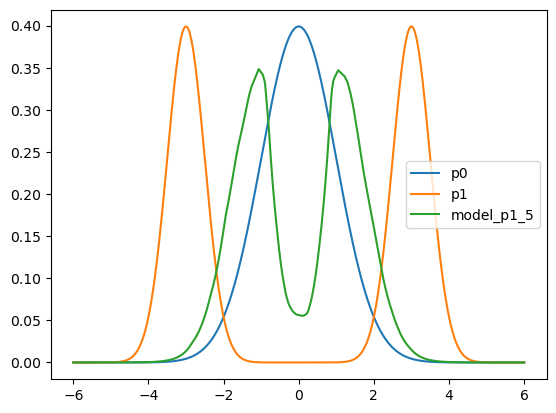

T:  4
Time:  5 iteration:  0 loss:  2.054673910140991 acc:  0.5 kl_div:  tensor(-9.2762, device='cuda:0') mse:  tensor(1.1424, device='cuda:0') js_div:  [0.0001045]
Time:  5 iteration:  100 loss:  1.528731346130371 acc:  0.48885 kl_div:  tensor(13261.3018, device='cuda:0') mse:  tensor(0.5559, device='cuda:0') js_div:  [0.01560245]
Time:  5 iteration:  200 loss:  1.4718844890594482 acc:  0.4839 kl_div:  tensor(1335.5443, device='cuda:0') mse:  tensor(0.0147, device='cuda:0') js_div:  [0.00470104]
Time:  5 iteration:  300 loss:  1.4680589437484741 acc:  0.4846 kl_div:  tensor(64.8183, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00026083]
Time:  5 iteration:  400 loss:  1.4532136917114258 acc:  0.49045 kl_div:  tensor(28.5044, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.0002643]
Time:  5 iteration:  500 loss:  1.442650318145752 acc:  0.49195 kl_div:  tensor(23.3725, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00030173]


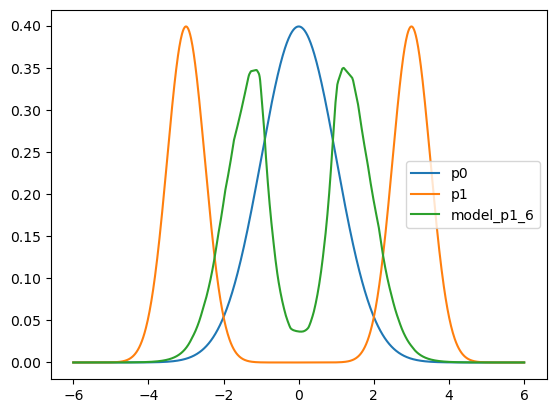

Time:  5 iteration:  0 loss:  1.3813211917877197 acc:  0.270475 kl_div:  tensor(-7.6277, device='cuda:0') mse:  tensor(0.0680, device='cuda:0') js_div:  [0.02988673]
Time:  5 iteration:  100 loss:  1.3812041282653809 acc:  0.2711 kl_div:  tensor(19.3330, device='cuda:0') mse:  tensor(4.9900e-05, device='cuda:0') js_div:  [9.7794116e-05]
Time:  5 iteration:  200 loss:  1.381164789199829 acc:  0.271625 kl_div:  tensor(-0.9550, device='cuda:0') mse:  tensor(1.6254e-05, device='cuda:0') js_div:  [3.707536e-05]
Time:  5 iteration:  300 loss:  1.3811675310134888 acc:  0.2695 kl_div:  tensor(1.6641, device='cuda:0') mse:  tensor(1.6188e-05, device='cuda:0') js_div:  [4.3145243e-05]
Time:  5 iteration:  400 loss:  1.3810664415359497 acc:  0.2719 kl_div:  tensor(0.7287, device='cuda:0') mse:  tensor(2.1256e-05, device='cuda:0') js_div:  [4.7472888e-05]
Time:  5 iteration:  500 loss:  1.3811674118041992 acc:  0.27095 kl_div:  tensor(1.3593, device='cuda:0') mse:  tensor(3.0411e-05, device='cuda:

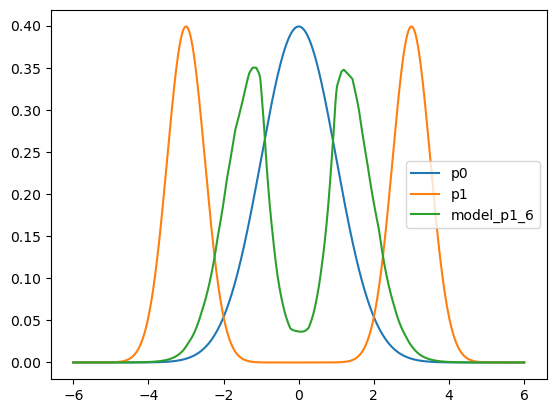

T:  5
Time:  6 iteration:  0 loss:  2.0143070220947266 acc:  0.5 kl_div:  tensor(-9.1892, device='cuda:0') mse:  tensor(0.9678, device='cuda:0') js_div:  [0.00060265]
Time:  6 iteration:  100 loss:  1.5168509483337402 acc:  0.4802 kl_div:  tensor(13203.1367, device='cuda:0') mse:  tensor(0.5102, device='cuda:0') js_div:  [0.01760691]
Time:  6 iteration:  200 loss:  1.4940992593765259 acc:  0.48615 kl_div:  tensor(496.4537, device='cuda:0') mse:  tensor(0.0033, device='cuda:0') js_div:  [0.00139236]
Time:  6 iteration:  300 loss:  1.4763693809509277 acc:  0.48995 kl_div:  tensor(98.7517, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00074438]
Time:  6 iteration:  400 loss:  1.466615915298462 acc:  0.49475 kl_div:  tensor(66.5855, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00061077]
Time:  6 iteration:  500 loss:  1.4490437507629395 acc:  0.50195 kl_div:  tensor(33.7256, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.000506

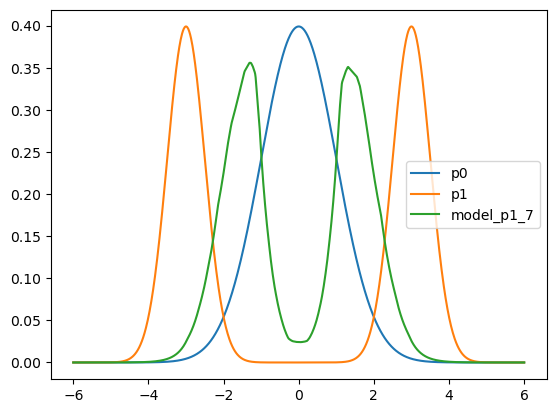

Time:  6 iteration:  0 loss:  1.3812425136566162 acc:  0.2702 kl_div:  tensor(-7.6160, device='cuda:0') mse:  tensor(0.0688, device='cuda:0') js_div:  [0.03173508]
Time:  6 iteration:  100 loss:  1.3807518482208252 acc:  0.26955 kl_div:  tensor(-8.4389, device='cuda:0') mse:  tensor(6.2459e-05, device='cuda:0') js_div:  [0.0001139]
Time:  6 iteration:  200 loss:  1.3810060024261475 acc:  0.271075 kl_div:  tensor(5.5490, device='cuda:0') mse:  tensor(1.8459e-05, device='cuda:0') js_div:  [4.7505775e-05]
Time:  6 iteration:  300 loss:  1.3811776638031006 acc:  0.2716 kl_div:  tensor(4.9752, device='cuda:0') mse:  tensor(1.8095e-05, device='cuda:0') js_div:  [3.649904e-05]
Time:  6 iteration:  400 loss:  1.3810627460479736 acc:  0.27175 kl_div:  tensor(-5.4947, device='cuda:0') mse:  tensor(1.0113e-05, device='cuda:0') js_div:  [2.4199178e-05]
Time:  6 iteration:  500 loss:  1.3810151815414429 acc:  0.271225 kl_div:  tensor(16.0956, device='cuda:0') mse:  tensor(6.0266e-05, device='cuda:0

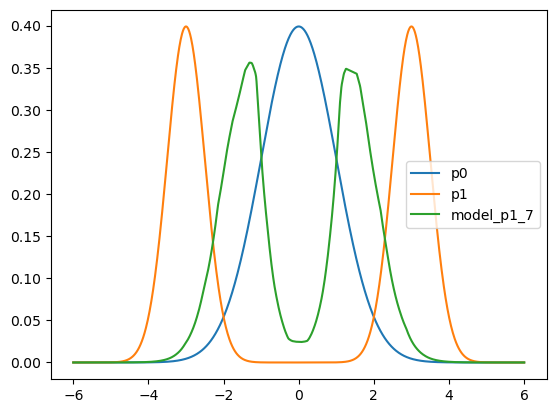

T:  6
Time:  7 iteration:  0 loss:  1.9007999897003174 acc:  0.5 kl_div:  tensor(-9.0050, device='cuda:0') mse:  tensor(0.7778, device='cuda:0') js_div:  [0.01021096]
Time:  7 iteration:  100 loss:  1.5073777437210083 acc:  0.4898 kl_div:  tensor(11399.5928, device='cuda:0') mse:  tensor(0.4287, device='cuda:0') js_div:  [0.01414507]
Time:  7 iteration:  200 loss:  1.491378664970398 acc:  0.4901 kl_div:  tensor(163.7519, device='cuda:0') mse:  tensor(0.0008, device='cuda:0') js_div:  [0.00107299]
Time:  7 iteration:  300 loss:  1.4819796085357666 acc:  0.4903 kl_div:  tensor(48.2783, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00034009]
Time:  7 iteration:  400 loss:  1.4719442129135132 acc:  0.4975 kl_div:  tensor(36.3834, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00034403]
Time:  7 iteration:  500 loss:  1.4553391933441162 acc:  0.499 kl_div:  tensor(15.8018, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00039055]
T

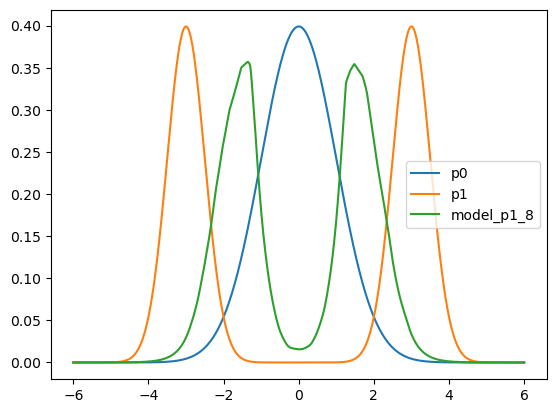

Time:  7 iteration:  0 loss:  1.3809928894042969 acc:  0.270575 kl_div:  tensor(-7.6472, device='cuda:0') mse:  tensor(0.0729, device='cuda:0') js_div:  [0.03138308]
Time:  7 iteration:  100 loss:  1.3810837268829346 acc:  0.271125 kl_div:  tensor(52.5202, device='cuda:0') mse:  tensor(8.3527e-05, device='cuda:0') js_div:  [9.301775e-05]
Time:  7 iteration:  200 loss:  1.3811733722686768 acc:  0.270975 kl_div:  tensor(-15.1969, device='cuda:0') mse:  tensor(2.7431e-05, device='cuda:0') js_div:  [5.492331e-05]
Time:  7 iteration:  300 loss:  1.380937099456787 acc:  0.27165 kl_div:  tensor(3.7030, device='cuda:0') mse:  tensor(1.6382e-05, device='cuda:0') js_div:  [3.950511e-05]
Time:  7 iteration:  400 loss:  1.3810088634490967 acc:  0.270575 kl_div:  tensor(-44.4808, device='cuda:0') mse:  tensor(5.3382e-05, device='cuda:0') js_div:  [4.7603135e-05]
Time:  7 iteration:  500 loss:  1.3808939456939697 acc:  0.271575 kl_div:  tensor(21.7133, device='cuda:0') mse:  tensor(1.1221e-05, devic

In [16]:
model = train(u,15000,lr=1e-4,mala=True)

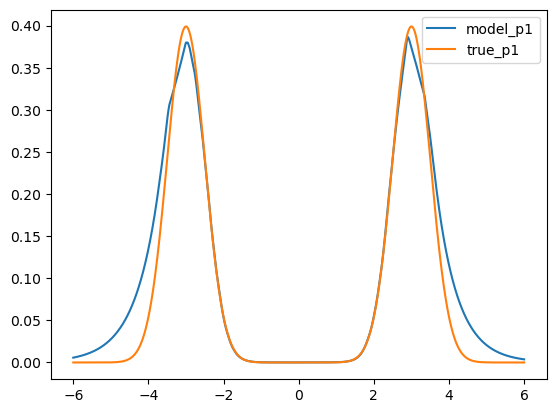

In [ ]:
x=np.linspace(-6, 6, 1000)
x=torch.Tensor(x).cuda().unsqueeze(1)
true_energy=p_1.log_prob(x.detach().cpu()).squeeze().numpy()
energy=model(x).detach().cpu().squeeze().numpy()
x=x.cpu().squeeze().numpy()
plt.plot(x, np.exp(energy),label='model_p1')
plt.plot(x, np.exp(true_energy), label='true_p1')
plt.legend()

## Now with BAR correction at each time step

Time:  0 iteration:  0 loss:  1.9498298168182373 acc:  0.5 kl_div:  tensor(-9.2951, device='cuda:0') mse:  tensor(1.2058, device='cuda:0') js_div:  [0.00112631]
Time:  0 iteration:  100 loss:  1.4359774589538574 acc:  0.5 kl_div:  tensor(13166.5010, device='cuda:0') mse:  tensor(0.5791, device='cuda:0') js_div:  [0.00928958]
Time:  0 iteration:  200 loss:  1.3931893110275269 acc:  0.5222 kl_div:  tensor(1228.7224, device='cuda:0') mse:  tensor(0.0106, device='cuda:0') js_div:  [0.00137909]
Time:  0 iteration:  300 loss:  1.3907396793365479 acc:  0.523 kl_div:  tensor(-43.0953, device='cuda:0') mse:  tensor(5.6222e-05, device='cuda:0') js_div:  [8.528224e-05]
Time:  0 iteration:  400 loss:  1.388181209564209 acc:  0.5256 kl_div:  tensor(-30.2554, device='cuda:0') mse:  tensor(2.9305e-05, device='cuda:0') js_div:  [5.3341464e-05]
Time:  0 iteration:  500 loss:  1.3873149156570435 acc:  0.52785 kl_div:  tensor(-27.2726, device='cuda:0') mse:  tensor(1.8165e-05, device='cuda:0') js_div:  [

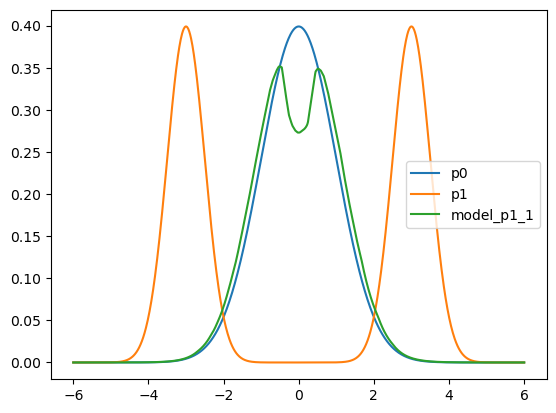

T:  0
Time:  1 iteration:  0 loss:  1.9983587793932456 acc:  0.5 kl_div:  tensor(-9.3108, device='cuda:0') mse:  tensor(1.2313, device='cuda:0') js_div:  [0.00044657]
Time:  1 iteration:  100 loss:  1.4492908452083857 acc:  0.5 kl_div:  tensor(14010.5117, device='cuda:0') mse:  tensor(0.6240, device='cuda:0') js_div:  [0.01240482]
Time:  1 iteration:  200 loss:  1.406393033547166 acc:  0.49045 kl_div:  tensor(1265.6354, device='cuda:0') mse:  tensor(0.0109, device='cuda:0') js_div:  [0.00112088]
Time:  1 iteration:  300 loss:  1.39927000384287 acc:  0.49465 kl_div:  tensor(-19.5065, device='cuda:0') mse:  tensor(1.9166e-05, device='cuda:0') js_div:  [4.6292094e-05]
Time:  1 iteration:  400 loss:  1.39751624945817 acc:  0.4917 kl_div:  tensor(-14.1080, device='cuda:0') mse:  tensor(1.2084e-05, device='cuda:0') js_div:  [3.0121899e-05]
Time:  1 iteration:  500 loss:  1.3949716495152205 acc:  0.4967 kl_div:  tensor(-11.1679, device='cuda:0') mse:  tensor(1.3951e-05, device='cuda:0') js_di

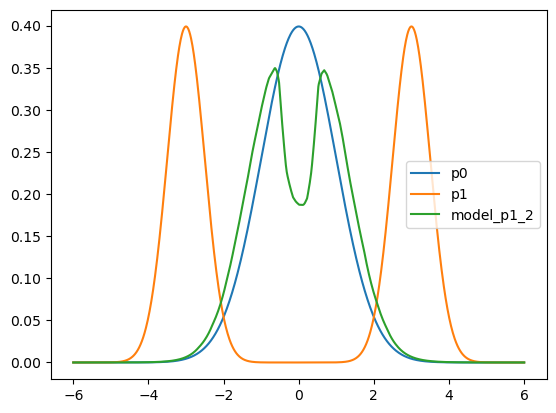

T:  1
Time:  2 iteration:  0 loss:  1.9747019180987606 acc:  0.5 kl_div:  tensor(-9.2285, device='cuda:0') mse:  tensor(1.0494, device='cuda:0') js_div:  [0.00075157]
Time:  2 iteration:  100 loss:  1.4780905974181997 acc:  0.5 kl_div:  tensor(11584.1543, device='cuda:0') mse:  tensor(0.4738, device='cuda:0') js_div:  [0.01347546]
Time:  2 iteration:  200 loss:  1.424015163769321 acc:  0.4843 kl_div:  tensor(1478.8643, device='cuda:0') mse:  tensor(0.0147, device='cuda:0') js_div:  [0.00112535]
Time:  2 iteration:  300 loss:  1.4147788290196122 acc:  0.4862 kl_div:  tensor(44.4049, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00021441]
Time:  2 iteration:  400 loss:  1.4117062534429978 acc:  0.4902 kl_div:  tensor(24.3497, device='cuda:0') mse:  tensor(6.9331e-05, device='cuda:0') js_div:  [0.00012898]
Time:  2 iteration:  500 loss:  1.40633587390439 acc:  0.49145 kl_div:  tensor(16.0082, device='cuda:0') mse:  tensor(5.5870e-05, device='cuda:0') js_div:  [0.00012

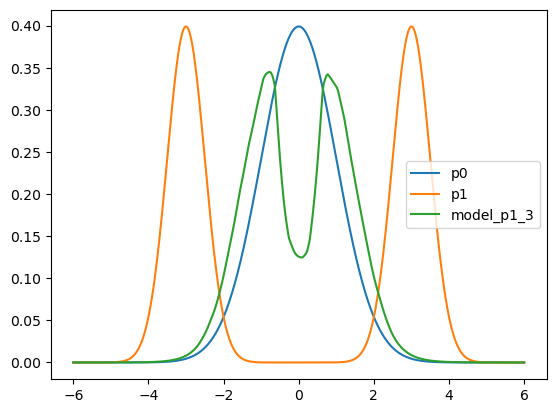

T:  2
Time:  3 iteration:  0 loss:  1.9306866913528755 acc:  0.5 kl_div:  tensor(-9.1185, device='cuda:0') mse:  tensor(0.8394, device='cuda:0') js_div:  [0.00053608]
Time:  3 iteration:  100 loss:  1.4701100343338656 acc:  0.49475 kl_div:  tensor(11071.2227, device='cuda:0') mse:  tensor(0.4073, device='cuda:0') js_div:  [0.01360379]
Time:  3 iteration:  200 loss:  1.4371811548201463 acc:  0.48745 kl_div:  tensor(860.8105, device='cuda:0') mse:  tensor(0.0059, device='cuda:0') js_div:  [0.00075906]
Time:  3 iteration:  300 loss:  1.433277022999801 acc:  0.48755 kl_div:  tensor(23.2078, device='cuda:0') mse:  tensor(4.4537e-05, device='cuda:0') js_div:  [8.691173e-05]
Time:  3 iteration:  400 loss:  1.4272582239115055 acc:  0.4936 kl_div:  tensor(5.8744, device='cuda:0') mse:  tensor(3.8717e-05, device='cuda:0') js_div:  [9.290644e-05]
Time:  3 iteration:  500 loss:  1.4216820312900804 acc:  0.49455 kl_div:  tensor(2.1293, device='cuda:0') mse:  tensor(4.8371e-05, device='cuda:0') js_d

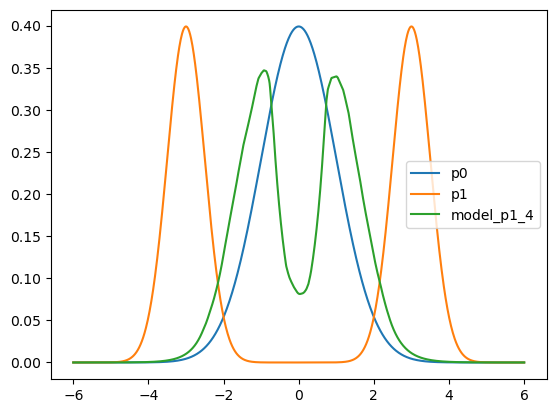

T:  3
Time:  4 iteration:  0 loss:  1.9780750045669135 acc:  0.5 kl_div:  tensor(-9.1545, device='cuda:0') mse:  tensor(0.9257, device='cuda:0') js_div:  [0.00221636]
Time:  4 iteration:  100 loss:  1.5466778337449525 acc:  0.4903 kl_div:  tensor(9818.0918, device='cuda:0') mse:  tensor(0.3633, device='cuda:0') js_div:  [0.0102914]
Time:  4 iteration:  200 loss:  1.4718435308332196 acc:  0.48065 kl_div:  tensor(1719.3855, device='cuda:0') mse:  tensor(0.0233, device='cuda:0') js_div:  [0.00756845]
Time:  4 iteration:  300 loss:  1.4637290870058726 acc:  0.48205 kl_div:  tensor(92.6309, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00027346]
Time:  4 iteration:  400 loss:  1.4512539721465179 acc:  0.4849 kl_div:  tensor(40.9977, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00020262]
Time:  4 iteration:  500 loss:  1.4453825426019173 acc:  0.48955 kl_div:  tensor(26.0796, device='cuda:0') mse:  tensor(8.7829e-05, device='cuda:0') js_div:  [0.000

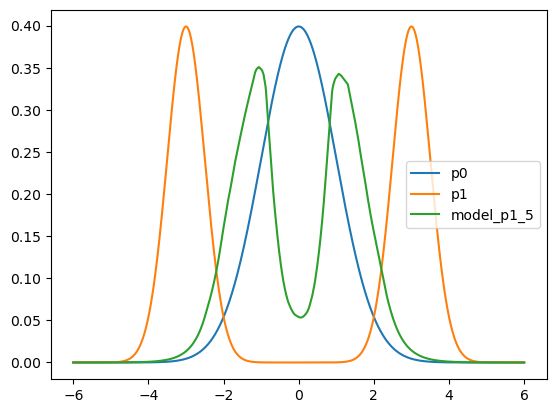

T:  4
Time:  5 iteration:  0 loss:  1.9087553334584932 acc:  0.5 kl_div:  tensor(-9.0193, device='cuda:0') mse:  tensor(0.7335, device='cuda:0') js_div:  [0.00461615]
Time:  5 iteration:  100 loss:  1.49904204603652 acc:  0.4886 kl_div:  tensor(9784.4414, device='cuda:0') mse:  tensor(0.3433, device='cuda:0') js_div:  [0.01587417]
Time:  5 iteration:  200 loss:  1.4736789185110053 acc:  0.48605 kl_div:  tensor(625.0292, device='cuda:0') mse:  tensor(0.0035, device='cuda:0') js_div:  [0.00010679]
Time:  5 iteration:  300 loss:  1.4643551318743788 acc:  0.48875 kl_div:  tensor(74.7165, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00045684]
Time:  5 iteration:  400 loss:  1.450658302616854 acc:  0.4921 kl_div:  tensor(45.8382, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00040557]
Time:  5 iteration:  500 loss:  1.4377147384013982 acc:  0.4985 kl_div:  tensor(17.1545, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00040966]
T

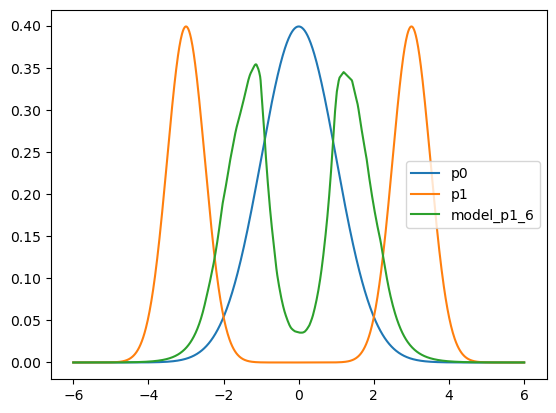

T:  5
Time:  6 iteration:  0 loss:  2.0414447595940586 acc:  0.5 kl_div:  tensor(-9.2558, device='cuda:0') mse:  tensor(1.1038, device='cuda:0') js_div:  [0.00050047]
Time:  6 iteration:  100 loss:  1.5498168182633705 acc:  0.4931 kl_div:  tensor(12512.4453, device='cuda:0') mse:  tensor(0.5222, device='cuda:0') js_div:  [0.01187538]
Time:  6 iteration:  200 loss:  1.498321650729593 acc:  0.48285 kl_div:  tensor(1354.8162, device='cuda:0') mse:  tensor(0.0141, device='cuda:0') js_div:  [0.00295209]
Time:  6 iteration:  300 loss:  1.4894335124227192 acc:  0.48835 kl_div:  tensor(68.9638, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00037433]
Time:  6 iteration:  400 loss:  1.4774124867281415 acc:  0.4891 kl_div:  tensor(58.9075, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00035303]
Time:  6 iteration:  500 loss:  1.4656163404922258 acc:  0.49425 kl_div:  tensor(38.4858, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.000402

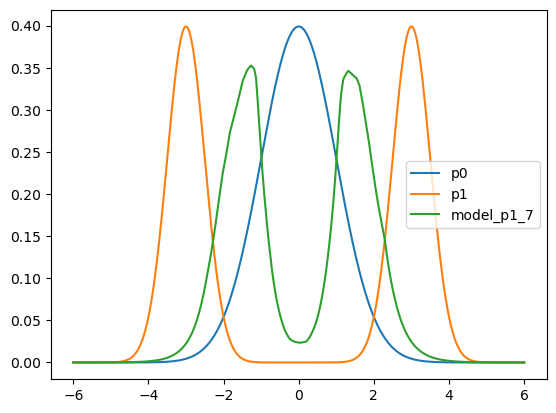

T:  6
Time:  7 iteration:  0 loss:  2.0615045974391553 acc:  0.5 kl_div:  tensor(-9.2794, device='cuda:0') mse:  tensor(1.1786, device='cuda:0') js_div:  [0.00164098]
Time:  7 iteration:  100 loss:  1.5178033926959564 acc:  0.4881 kl_div:  tensor(15745.7100, device='cuda:0') mse:  tensor(0.6873, device='cuda:0') js_div:  [0.01809037]
Time:  7 iteration:  200 loss:  1.501248165998848 acc:  0.4863 kl_div:  tensor(494.9628, device='cuda:0') mse:  tensor(0.0023, device='cuda:0') js_div:  [9.1469556e-05]
Time:  7 iteration:  300 loss:  1.4953151046470385 acc:  0.48995 kl_div:  tensor(74.3779, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00039702]
Time:  7 iteration:  400 loss:  1.4809958446525937 acc:  0.48995 kl_div:  tensor(53.1117, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00032024]
Time:  7 iteration:  500 loss:  1.470284215623881 acc:  0.49455 kl_div:  tensor(38.7892, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00036

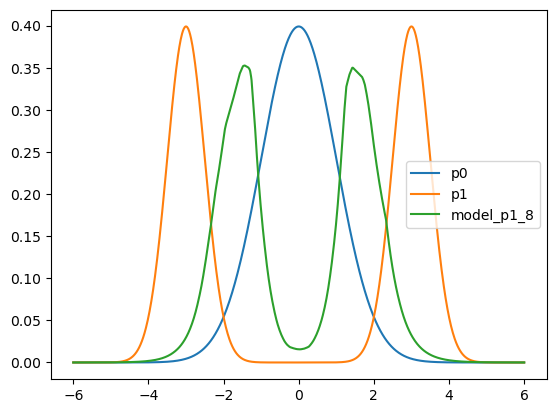

T:  7
Time:  8 iteration:  0 loss:  2.345258518942249 acc:  0.5 kl_div:  tensor(-9.6936, device='cuda:0') mse:  tensor(2.7342, device='cuda:0') js_div:  [0.00244692]
Time:  8 iteration:  100 loss:  1.630447147207551 acc:  0.5 kl_div:  tensor(22527.6445, device='cuda:0') mse:  tensor(1.5199, device='cuda:0') js_div:  [0.01058075]
Time:  8 iteration:  200 loss:  1.5136869510212991 acc:  0.48455 kl_div:  tensor(2784.7151, device='cuda:0') mse:  tensor(0.0446, device='cuda:0') js_div:  [0.00447601]
Time:  8 iteration:  300 loss:  1.509803096866081 acc:  0.49065 kl_div:  tensor(31.7726, device='cuda:0') mse:  tensor(6.0676e-05, device='cuda:0') js_div:  [8.2895305e-05]
Time:  8 iteration:  400 loss:  1.506979636176911 acc:  0.49195 kl_div:  tensor(24.5254, device='cuda:0') mse:  tensor(5.1934e-05, device='cuda:0') js_div:  [7.7771445e-05]
Time:  8 iteration:  500 loss:  1.497904173436313 acc:  0.49145 kl_div:  tensor(35.3397, device='cuda:0') mse:  tensor(6.0021e-05, device='cuda:0') js_div

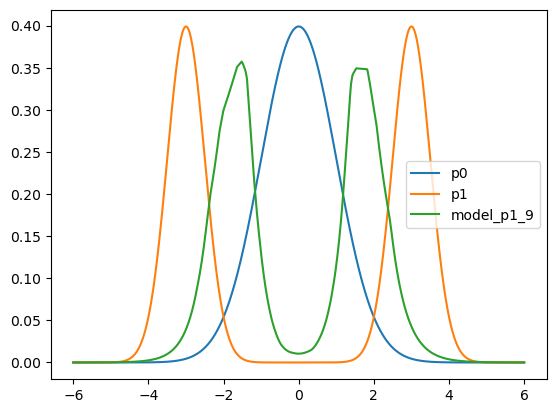

T:  8
Time:  9 iteration:  0 loss:  1.9147131533325967 acc:  0.5 kl_div:  tensor(-9.0349, device='cuda:0') mse:  tensor(0.7087, device='cuda:0') js_div:  [0.00042265]
Time:  9 iteration:  100 loss:  1.522090426474712 acc:  0.48625 kl_div:  tensor(10896.1816, device='cuda:0') mse:  tensor(0.3648, device='cuda:0') js_div:  [0.01044328]
Time:  9 iteration:  200 loss:  1.5112433844004105 acc:  0.49195 kl_div:  tensor(88.4765, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00027622]
Time:  9 iteration:  300 loss:  1.4947559556626517 acc:  0.49645 kl_div:  tensor(43.3553, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00024647]
Time:  9 iteration:  400 loss:  1.486003688066611 acc:  0.49595 kl_div:  tensor(38.9346, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00033037]
Time:  9 iteration:  500 loss:  1.4741419062677763 acc:  0.4989 kl_div:  tensor(32.9948, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00042242

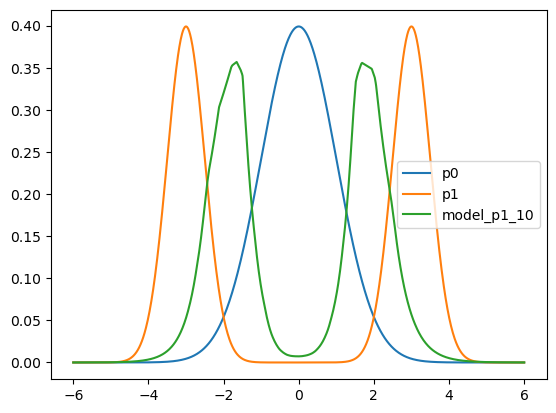

T:  9
Time:  10 iteration:  0 loss:  1.8334096060985268 acc:  0.5 kl_div:  tensor(-8.8682, device='cuda:0') mse:  tensor(0.5503, device='cuda:0') js_div:  [0.00557241]
Time:  10 iteration:  100 loss:  1.520347845558216 acc:  0.4869 kl_div:  tensor(8405.3691, device='cuda:0') mse:  tensor(0.2592, device='cuda:0') js_div:  [0.00994809]
Time:  10 iteration:  200 loss:  1.5044059849610183 acc:  0.49065 kl_div:  tensor(121.4694, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00037607]
Time:  10 iteration:  300 loss:  1.4987710149205702 acc:  0.49405 kl_div:  tensor(39.7658, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.0002324]
Time:  10 iteration:  400 loss:  1.4851987313733077 acc:  0.49835 kl_div:  tensor(27.8162, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00033128]
Time:  10 iteration:  500 loss:  1.4765196681795 acc:  0.49935 kl_div:  tensor(34.6398, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00039

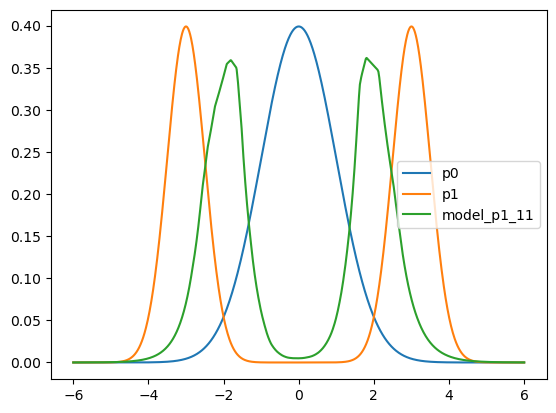

T:  10
Time:  11 iteration:  0 loss:  1.9889398595512155 acc:  0.5 kl_div:  tensor(-9.1905, device='cuda:0') mse:  tensor(0.9656, device='cuda:0') js_div:  [0.00030643]
Time:  11 iteration:  100 loss:  1.5146116369411837 acc:  0.4926 kl_div:  tensor(13996.2900, device='cuda:0') mse:  tensor(0.5500, device='cuda:0') js_div:  [0.00991972]
Time:  11 iteration:  200 loss:  1.5066142613180733 acc:  0.4935 kl_div:  tensor(116.0770, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00023589]
Time:  11 iteration:  300 loss:  1.505089049473434 acc:  0.49445 kl_div:  tensor(40.6663, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00016082]
Time:  11 iteration:  400 loss:  1.4934516567914544 acc:  0.4957 kl_div:  tensor(24.6391, device='cuda:0') mse:  tensor(9.7054e-05, device='cuda:0') js_div:  [0.0001736]
Time:  11 iteration:  500 loss:  1.477354816442107 acc:  0.49805 kl_div:  tensor(21.8255, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0

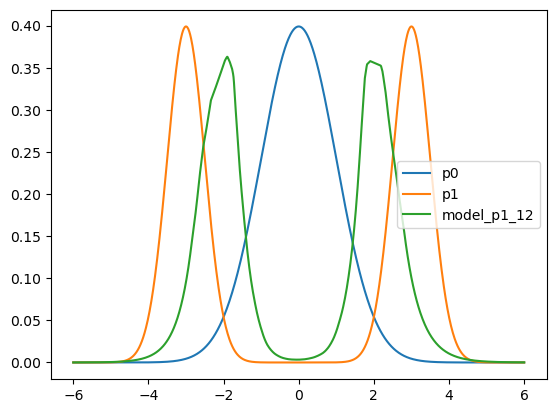

T:  11
Time:  12 iteration:  0 loss:  1.729312416118924 acc:  0.5 kl_div:  tensor(-8.7134, device='cuda:0') mse:  tensor(0.3794, device='cuda:0') js_div:  [0.00157502]
Time:  12 iteration:  100 loss:  1.5065569933431417 acc:  0.4965 kl_div:  tensor(6010.1855, device='cuda:0') mse:  tensor(0.1468, device='cuda:0') js_div:  [0.0037761]
Time:  12 iteration:  200 loss:  1.4904142913410374 acc:  0.502 kl_div:  tensor(32.8276, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00034307]
Time:  12 iteration:  300 loss:  1.4892310025581192 acc:  0.50065 kl_div:  tensor(48.3342, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.0003684]
Time:  12 iteration:  400 loss:  1.4768057597936823 acc:  0.50485 kl_div:  tensor(18.4148, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00038763]
Time:  12 iteration:  500 loss:  1.45621411570593 acc:  0.5062 kl_div:  tensor(6.7430, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00039699]

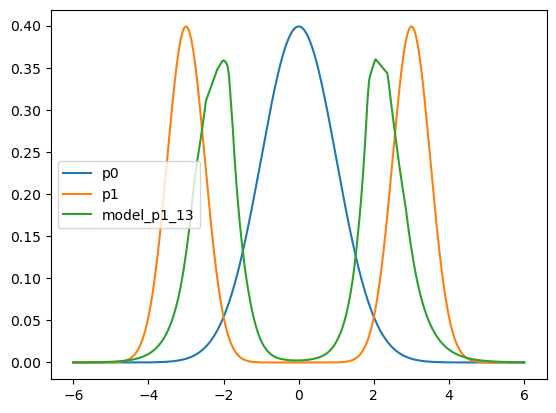

T:  12
Time:  13 iteration:  0 loss:  2.11529605113395 acc:  0.5 kl_div:  tensor(-9.3960, device='cuda:0') mse:  tensor(1.6802, device='cuda:0') js_div:  [0.00934076]
Time:  13 iteration:  100 loss:  1.51993106652423 acc:  0.49455 kl_div:  tensor(19820.6875, device='cuda:0') mse:  tensor(1.0714, device='cuda:0') js_div:  [0.01241877]
Time:  13 iteration:  200 loss:  1.5083342302295513 acc:  0.49705 kl_div:  tensor(352.5605, device='cuda:0') mse:  tensor(0.0018, device='cuda:0') js_div:  [0.00119914]
Time:  13 iteration:  300 loss:  1.499068863492127 acc:  0.495 kl_div:  tensor(37.0174, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00016933]
Time:  13 iteration:  400 loss:  1.4921738851068218 acc:  0.4989 kl_div:  tensor(22.7260, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00021198]
Time:  13 iteration:  500 loss:  1.484370790223631 acc:  0.50005 kl_div:  tensor(24.2131, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.000219

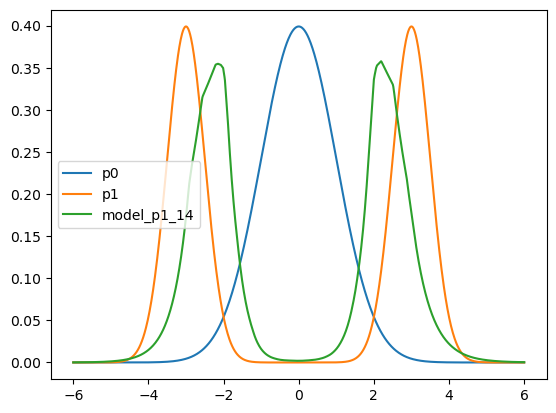

T:  13
Time:  14 iteration:  0 loss:  2.0325830322145015 acc:  0.5 kl_div:  tensor(-9.2897, device='cuda:0') mse:  tensor(1.2133, device='cuda:0') js_div:  [0.00218444]
Time:  14 iteration:  100 loss:  1.5198440575482974 acc:  0.4955 kl_div:  tensor(16030.6807, device='cuda:0') mse:  tensor(0.7153, device='cuda:0') js_div:  [0.01020094]
Time:  14 iteration:  200 loss:  1.5146464822419161 acc:  0.4956 kl_div:  tensor(192.5547, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00024881]
Time:  14 iteration:  300 loss:  1.5055854516118532 acc:  0.4941 kl_div:  tensor(39.7483, device='cuda:0') mse:  tensor(8.5229e-05, device='cuda:0') js_div:  [9.880102e-05]
Time:  14 iteration:  400 loss:  1.5007933882517674 acc:  0.497 kl_div:  tensor(31.8238, device='cuda:0') mse:  tensor(9.1412e-05, device='cuda:0') js_div:  [0.00013612]
Time:  14 iteration:  500 loss:  1.4899931382247291 acc:  0.50175 kl_div:  tensor(29.8943, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_d

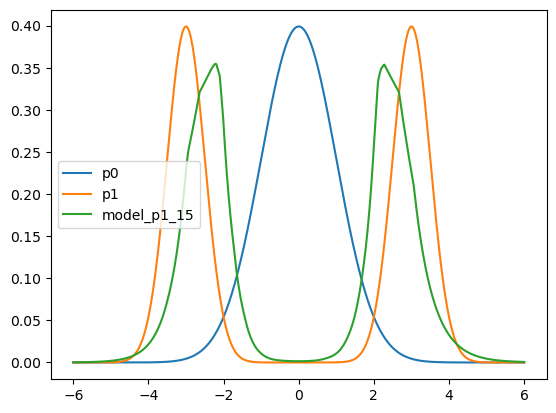

T:  14
Time:  15 iteration:  0 loss:  2.016938110063243 acc:  0.5 kl_div:  tensor(-9.2768, device='cuda:0') mse:  tensor(1.1424, device='cuda:0') js_div:  [2.536246e-05]
Time:  15 iteration:  100 loss:  1.5163313319411307 acc:  0.49645 kl_div:  tensor(15079.4004, device='cuda:0') mse:  tensor(0.6431, device='cuda:0') js_div:  [0.00933296]
Time:  15 iteration:  200 loss:  1.499326633637506 acc:  0.493 kl_div:  tensor(298.3979, device='cuda:0') mse:  tensor(0.0019, device='cuda:0') js_div:  [0.00207981]
Time:  15 iteration:  300 loss:  1.4995216118301036 acc:  0.4945 kl_div:  tensor(32.5636, device='cuda:0') mse:  tensor(8.4692e-05, device='cuda:0') js_div:  [0.00011153]
Time:  15 iteration:  400 loss:  1.4877152761228134 acc:  0.5005 kl_div:  tensor(23.0383, device='cuda:0') mse:  tensor(9.9454e-05, device='cuda:0') js_div:  [0.00016165]
Time:  15 iteration:  500 loss:  1.4832510367507274 acc:  0.5015 kl_div:  tensor(32.6479, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div

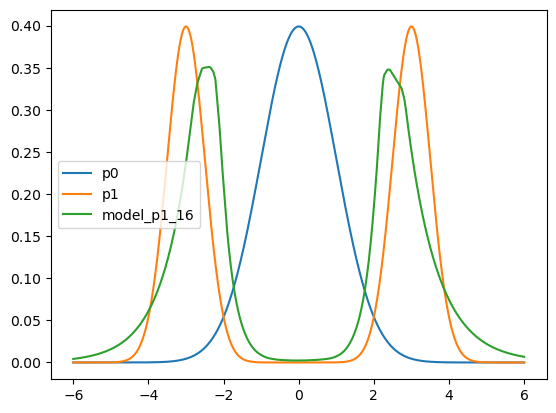

T:  15
Time:  16 iteration:  0 loss:  2.0075238709622623 acc:  0.5 kl_div:  tensor(-9.2711, device='cuda:0') mse:  tensor(1.3167, device='cuda:0') js_div:  [0.00980531]
Time:  16 iteration:  100 loss:  1.5091942768683748 acc:  0.4978 kl_div:  tensor(16645.8516, device='cuda:0') mse:  tensor(0.8071, device='cuda:0') js_div:  [0.01553889]
Time:  16 iteration:  200 loss:  1.5089811555883552 acc:  0.49795 kl_div:  tensor(59.2500, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.0001703]
Time:  16 iteration:  300 loss:  1.4973686284648329 acc:  0.503 kl_div:  tensor(33.1627, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00014104]
Time:  16 iteration:  400 loss:  1.4794699052436786 acc:  0.50715 kl_div:  tensor(31.2925, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00020737]
Time:  16 iteration:  500 loss:  1.471449879835498 acc:  0.5075 kl_div:  tensor(32.2997, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.0002

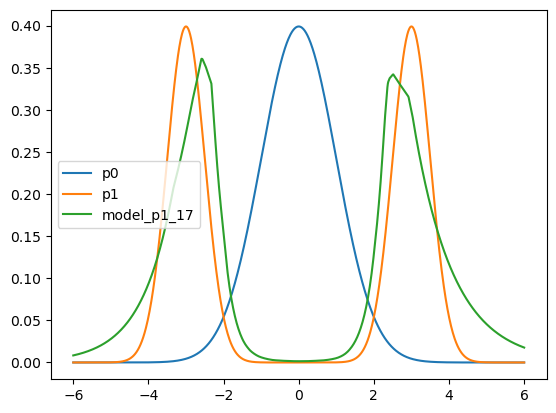

T:  16
Time:  17 iteration:  0 loss:  2.206359986524015 acc:  0.5 kl_div:  tensor(-9.6421, device='cuda:0') mse:  tensor(2.4218, device='cuda:0') js_div:  [0.00130606]
Time:  17 iteration:  100 loss:  1.5212669281171842 acc:  0.4974 kl_div:  tensor(25832.9531, device='cuda:0') mse:  tensor(1.5883, device='cuda:0') js_div:  [0.01132469]
Time:  17 iteration:  200 loss:  1.509114844755373 acc:  0.4903 kl_div:  tensor(406.1310, device='cuda:0') mse:  tensor(0.0017, device='cuda:0') js_div:  [0.00014822]
Time:  17 iteration:  300 loss:  1.4883845475136708 acc:  0.49775 kl_div:  tensor(48.5397, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.0002523]
Time:  17 iteration:  400 loss:  1.4837621026279988 acc:  0.50155 kl_div:  tensor(35.1684, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00033689]
Time:  17 iteration:  500 loss:  1.4704400648395817 acc:  0.504 kl_div:  tensor(33.3517, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.0003

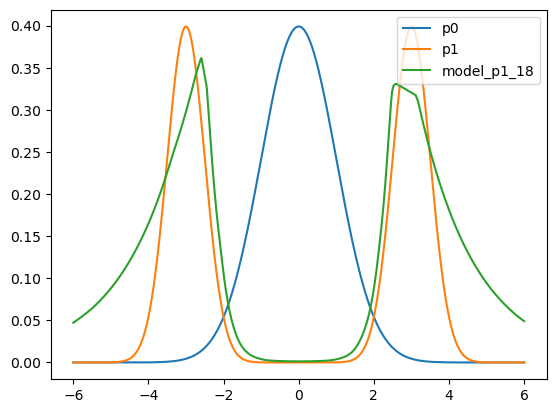

T:  17
Time:  18 iteration:  0 loss:  2.0406259629857466 acc:  0.5 kl_div:  tensor(-9.4410, device='cuda:0') mse:  tensor(1.7295, device='cuda:0') js_div:  [0.00542829]
Time:  18 iteration:  100 loss:  1.5168007291353407 acc:  0.4874 kl_div:  tensor(19175.9414, device='cuda:0') mse:  tensor(1.0492, device='cuda:0') js_div:  [0.00788404]
Time:  18 iteration:  200 loss:  1.5066724456386456 acc:  0.4809 kl_div:  tensor(270.6091, device='cuda:0') mse:  tensor(0.0015, device='cuda:0') js_div:  [0.00113564]
Time:  18 iteration:  300 loss:  1.4825706181557055 acc:  0.4901 kl_div:  tensor(37.0772, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00022682]
Time:  18 iteration:  400 loss:  1.473466225408047 acc:  0.50085 kl_div:  tensor(34.1180, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00043509]
Time:  18 iteration:  500 loss:  1.4627841385646398 acc:  0.5038 kl_div:  tensor(32.2230, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00

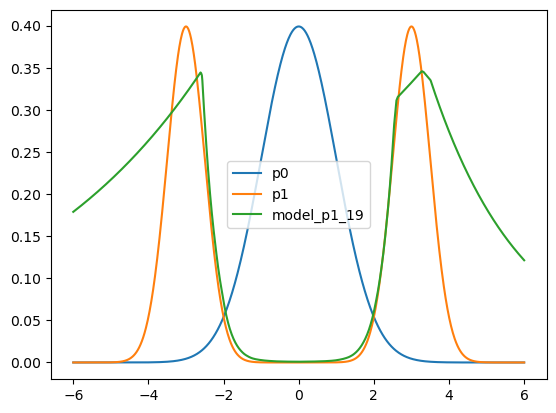

T:  18
Time:  19 iteration:  0 loss:  1.8957027373889082 acc:  0.5 kl_div:  tensor(-9.2564, device='cuda:0') mse:  tensor(1.1092, device='cuda:0') js_div:  [0.00073825]
Time:  19 iteration:  100 loss:  1.5124437187196458 acc:  0.4774 kl_div:  tensor(13388.1172, device='cuda:0') mse:  tensor(0.5727, device='cuda:0') js_div:  [0.00456987]
Time:  19 iteration:  200 loss:  1.5069402185024368 acc:  0.4769 kl_div:  tensor(-3.3594, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00025627]
Time:  19 iteration:  300 loss:  1.4853160733573085 acc:  0.48505 kl_div:  tensor(49.8077, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00041075]
Time:  19 iteration:  400 loss:  1.4841173289028493 acc:  0.48725 kl_div:  tensor(58.0964, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00065917]
Time:  19 iteration:  500 loss:  1.463873375838281 acc:  0.49925 kl_div:  tensor(39.1668, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.0

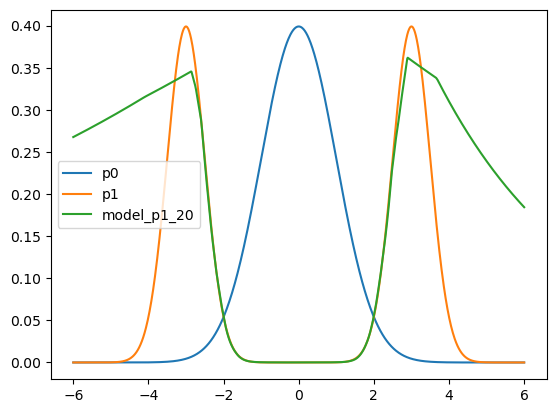

T:  19


In [38]:
model = train(u,30000,bar=True) 

## NCE with exponential loss

Time:  0 iteration:  0 loss:  2.895815134048462 acc:  0.5 kl_div:  tensor(-9.3030, device='cuda:0') mse:  tensor(1.2341, device='cuda:0') js_div:  [0.00152592]
Time:  0 iteration:  100 loss:  2.0585930347442627 acc:  0.52875 kl_div:  tensor(14510.8750, device='cuda:0') mse:  tensor(0.6536, device='cuda:0') js_div:  [0.01244377]
Time:  0 iteration:  200 loss:  2.0115904808044434 acc:  0.52325 kl_div:  tensor(913.6426, device='cuda:0') mse:  tensor(0.0061, device='cuda:0') js_div:  [0.00211289]
Time:  0 iteration:  300 loss:  2.0062897205352783 acc:  0.52035 kl_div:  tensor(-77.6729, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00035006]
Time:  0 iteration:  400 loss:  2.0021469593048096 acc:  0.5286 kl_div:  tensor(-57.8679, device='cuda:0') mse:  tensor(7.6879e-05, device='cuda:0') js_div:  [9.634934e-05]
Time:  0 iteration:  500 loss:  1.9986828565597534 acc:  0.53345 kl_div:  tensor(-34.6964, device='cuda:0') mse:  tensor(2.7032e-05, device='cuda:0') js_div:  [3

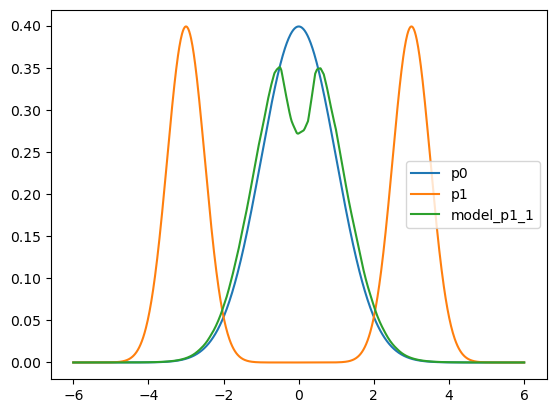

T:  0
Time:  1 iteration:  0 loss:  2.983335494995117 acc:  0.5 kl_div:  tensor(-9.4086, device='cuda:0') mse:  tensor(1.5039, device='cuda:0') js_div:  [0.00073794]
Time:  1 iteration:  100 loss:  2.072772979736328 acc:  0.5 kl_div:  tensor(16309.1807, device='cuda:0') mse:  tensor(0.7963, device='cuda:0') js_div:  [0.01169212]
Time:  1 iteration:  200 loss:  2.0233144760131836 acc:  0.48735 kl_div:  tensor(1330.0917, device='cuda:0') mse:  tensor(0.0121, device='cuda:0') js_div:  [0.0011448]
Time:  1 iteration:  300 loss:  2.019305944442749 acc:  0.48485 kl_div:  tensor(-15.5108, device='cuda:0') mse:  tensor(1.3297e-05, device='cuda:0') js_div:  [3.0653653e-05]
Time:  1 iteration:  400 loss:  2.0182604789733887 acc:  0.4855 kl_div:  tensor(-15.8677, device='cuda:0') mse:  tensor(1.5769e-05, device='cuda:0') js_div:  [3.4093508e-05]
Time:  1 iteration:  500 loss:  2.0142505168914795 acc:  0.489 kl_div:  tensor(-7.8943, device='cuda:0') mse:  tensor(2.3944e-05, device='cuda:0') js_div

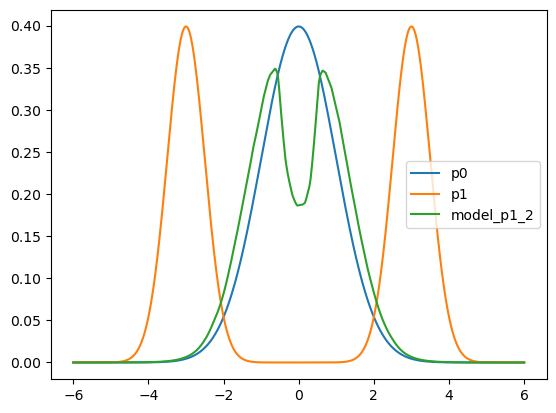

T:  1
Time:  2 iteration:  0 loss:  2.636528730392456 acc:  0.5 kl_div:  tensor(-9.0318, device='cuda:0') mse:  tensor(0.7061, device='cuda:0') js_div:  [0.00058423]
Time:  2 iteration:  100 loss:  2.0506930351257324 acc:  0.4933 kl_div:  tensor(9966.5684, device='cuda:0') mse:  tensor(0.3314, device='cuda:0') js_div:  [0.00757839]
Time:  2 iteration:  200 loss:  2.034752368927002 acc:  0.485 kl_div:  tensor(534.7639, device='cuda:0') mse:  tensor(0.0026, device='cuda:0') js_div:  [0.00083428]
Time:  2 iteration:  300 loss:  2.029963970184326 acc:  0.48805 kl_div:  tensor(-3.3696, device='cuda:0') mse:  tensor(2.1242e-05, device='cuda:0') js_div:  [6.20236e-05]
Time:  2 iteration:  400 loss:  2.021064043045044 acc:  0.48915 kl_div:  tensor(-15.7255, device='cuda:0') mse:  tensor(3.4229e-05, device='cuda:0') js_div:  [8.908955e-05]
Time:  2 iteration:  500 loss:  2.0169835090637207 acc:  0.49055 kl_div:  tensor(-15.2925, device='cuda:0') mse:  tensor(4.7695e-05, device='cuda:0') js_div:

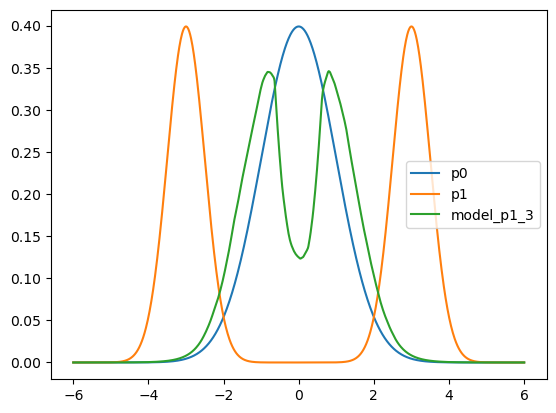

T:  2
Time:  3 iteration:  0 loss:  2.7519640922546387 acc:  0.5 kl_div:  tensor(-9.1091, device='cuda:0') mse:  tensor(0.8214, device='cuda:0') js_div:  [0.00036938]
Time:  3 iteration:  100 loss:  2.0797278881073 acc:  0.4939 kl_div:  tensor(11372.3242, device='cuda:0') mse:  tensor(0.4117, device='cuda:0') js_div:  [0.00968823]
Time:  3 iteration:  200 loss:  2.0542213916778564 acc:  0.48755 kl_div:  tensor(661.0520, device='cuda:0') mse:  tensor(0.0035, device='cuda:0') js_div:  [0.00061364]
Time:  3 iteration:  300 loss:  2.0436136722564697 acc:  0.48845 kl_div:  tensor(-12.8391, device='cuda:0') mse:  tensor(3.2658e-05, device='cuda:0') js_div:  [8.7653534e-05]
Time:  3 iteration:  400 loss:  2.0381581783294678 acc:  0.4907 kl_div:  tensor(-9.8115, device='cuda:0') mse:  tensor(4.6605e-05, device='cuda:0') js_div:  [0.00012464]
Time:  3 iteration:  500 loss:  2.031611204147339 acc:  0.4902 kl_div:  tensor(-17.7691, device='cuda:0') mse:  tensor(7.4776e-05, device='cuda:0') js_div

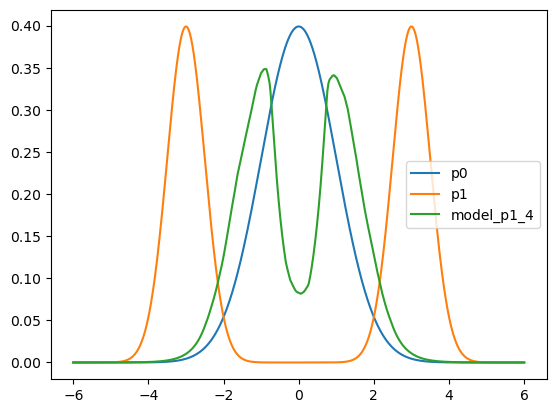

T:  3
Time:  4 iteration:  0 loss:  2.9662563800811768 acc:  0.5 kl_div:  tensor(-9.2824, device='cuda:0') mse:  tensor(1.1597, device='cuda:0') js_div:  [0.00026542]
Time:  4 iteration:  100 loss:  2.1738476753234863 acc:  0.5 kl_div:  tensor(12179.1934, device='cuda:0') mse:  tensor(0.5225, device='cuda:0') js_div:  [0.01246687]
Time:  4 iteration:  200 loss:  2.0880398750305176 acc:  0.48185 kl_div:  tensor(1924.1260, device='cuda:0') mse:  tensor(0.0227, device='cuda:0') js_div:  [0.0013851]
Time:  4 iteration:  300 loss:  2.075361728668213 acc:  0.48775 kl_div:  tensor(54.7917, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.0003089]
Time:  4 iteration:  400 loss:  2.0652060508728027 acc:  0.48865 kl_div:  tensor(40.7784, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00024424]
Time:  4 iteration:  500 loss:  2.0538032054901123 acc:  0.49355 kl_div:  tensor(16.8663, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00024287]


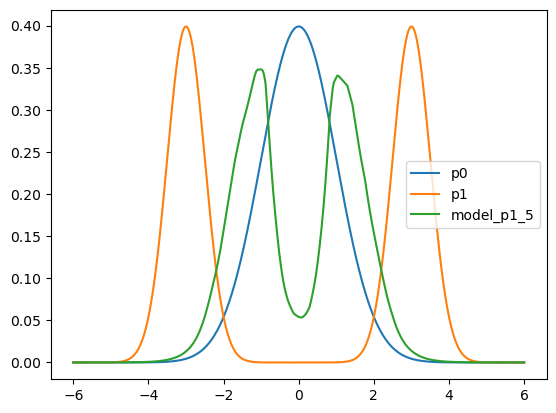

T:  4
Time:  5 iteration:  0 loss:  2.8365843296051025 acc:  0.5 kl_div:  tensor(-9.1609, device='cuda:0') mse:  tensor(0.9062, device='cuda:0') js_div:  [3.5086752e-05]
Time:  5 iteration:  100 loss:  2.112980604171753 acc:  0.4841 kl_div:  tensor(14198.3662, device='cuda:0') mse:  tensor(0.5275, device='cuda:0') js_div:  [0.01613694]
Time:  5 iteration:  200 loss:  2.090179443359375 acc:  0.48675 kl_div:  tensor(190.9944, device='cuda:0') mse:  tensor(0.0007, device='cuda:0') js_div:  [0.00057414]
Time:  5 iteration:  300 loss:  2.0745749473571777 acc:  0.4936 kl_div:  tensor(49.1883, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00047654]
Time:  5 iteration:  400 loss:  2.062191963195801 acc:  0.49705 kl_div:  tensor(12.8090, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00036664]
Time:  5 iteration:  500 loss:  2.050565004348755 acc:  0.4946 kl_div:  tensor(-6.5655, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00037984

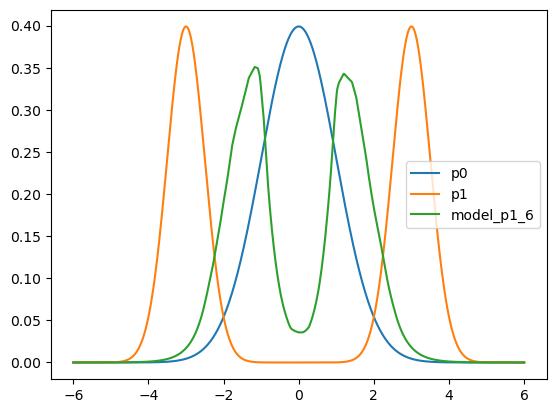

T:  5
Time:  6 iteration:  0 loss:  3.378739356994629 acc:  0.5 kl_div:  tensor(-9.6004, device='cuda:0') mse:  tensor(2.3029, device='cuda:0') js_div:  [0.00329547]
Time:  6 iteration:  100 loss:  2.3169260025024414 acc:  0.5 kl_div:  tensor(18188.3359, device='cuda:0') mse:  tensor(1.1520, device='cuda:0') js_div:  [0.01186839]
Time:  6 iteration:  200 loss:  2.126765012741089 acc:  0.4835 kl_div:  tensor(3608.0334, device='cuda:0') mse:  tensor(0.0616, device='cuda:0') js_div:  [0.00389623]
Time:  6 iteration:  300 loss:  2.1195452213287354 acc:  0.48695 kl_div:  tensor(43.2176, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00017368]
Time:  6 iteration:  400 loss:  2.1111903190612793 acc:  0.48995 kl_div:  tensor(37.6939, device='cuda:0') mse:  tensor(8.9466e-05, device='cuda:0') js_div:  [0.00015053]
Time:  6 iteration:  500 loss:  2.1036267280578613 acc:  0.4899 kl_div:  tensor(18.0659, device='cuda:0') mse:  tensor(7.7091e-05, device='cuda:0') js_div:  [0.000

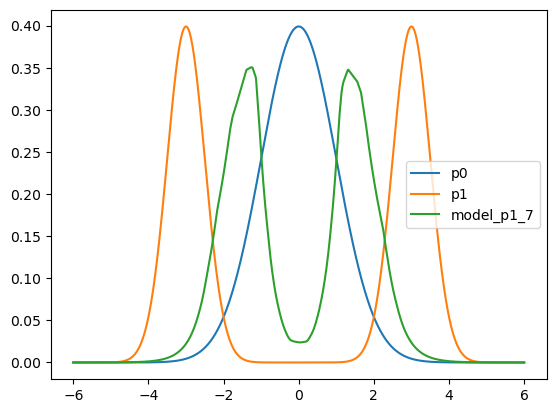

T:  6
Time:  7 iteration:  0 loss:  2.6496381759643555 acc:  0.5 kl_div:  tensor(-8.9580, device='cuda:0') mse:  tensor(0.6092, device='cuda:0') js_div:  [0.00059164]
Time:  7 iteration:  100 loss:  2.145705223083496 acc:  0.48345 kl_div:  tensor(10363.1230, device='cuda:0') mse:  tensor(0.3187, device='cuda:0') js_div:  [0.01002164]
Time:  7 iteration:  200 loss:  2.1261513233184814 acc:  0.4872 kl_div:  tensor(70.6397, device='cuda:0') mse:  tensor(0.0006, device='cuda:0') js_div:  [0.00105561]
Time:  7 iteration:  300 loss:  2.1056947708129883 acc:  0.49185 kl_div:  tensor(48.8943, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00057869]
Time:  7 iteration:  400 loss:  2.084109306335449 acc:  0.49295 kl_div:  tensor(10.7316, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00050287]
Time:  7 iteration:  500 loss:  2.068862199783325 acc:  0.50035 kl_div:  tensor(-8.0854, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00055461]

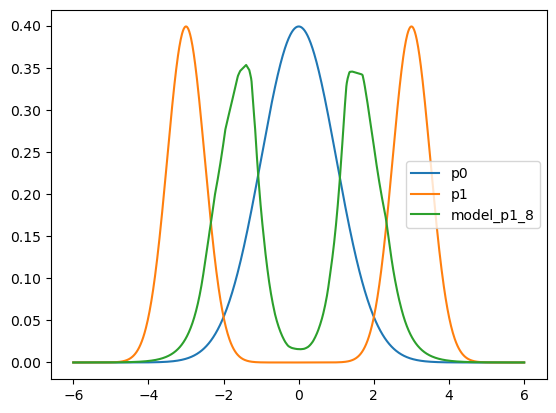

T:  7
Time:  8 iteration:  0 loss:  3.0816457271575928 acc:  0.5 kl_div:  tensor(-9.3774, device='cuda:0') mse:  tensor(1.4432, device='cuda:0') js_div:  [0.00206057]
Time:  8 iteration:  100 loss:  2.2721264362335205 acc:  0.49405 kl_div:  tensor(14214.2715, device='cuda:0') mse:  tensor(0.6832, device='cuda:0') js_div:  [0.00947883]
Time:  8 iteration:  200 loss:  2.1507468223571777 acc:  0.4862 kl_div:  tensor(2174.5693, device='cuda:0') mse:  tensor(0.0318, device='cuda:0') js_div:  [0.00666249]
Time:  8 iteration:  300 loss:  2.1338329315185547 acc:  0.48805 kl_div:  tensor(68.7562, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00067034]
Time:  8 iteration:  400 loss:  2.1111268997192383 acc:  0.49525 kl_div:  tensor(36.6613, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00058723]
Time:  8 iteration:  500 loss:  2.093745470046997 acc:  0.49705 kl_div:  tensor(22.9271, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00053

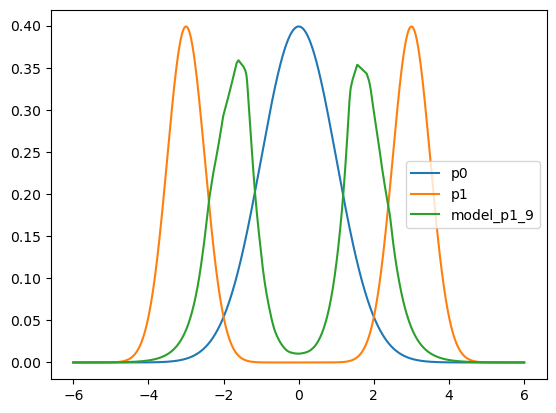

T:  8
Time:  9 iteration:  0 loss:  3.1267271041870117 acc:  0.5 kl_div:  tensor(-9.4096, device='cuda:0') mse:  tensor(1.5527, device='cuda:0') js_div:  [0.00257762]
Time:  9 iteration:  100 loss:  2.2252492904663086 acc:  0.48975 kl_div:  tensor(18111.8906, device='cuda:0') mse:  tensor(0.9132, device='cuda:0') js_div:  [0.01519402]
Time:  9 iteration:  200 loss:  2.157381296157837 acc:  0.48825 kl_div:  tensor(1032.3882, device='cuda:0') mse:  tensor(0.0083, device='cuda:0') js_div:  [0.00011851]
Time:  9 iteration:  300 loss:  2.144015312194824 acc:  0.49395 kl_div:  tensor(67.5381, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00057933]
Time:  9 iteration:  400 loss:  2.118490695953369 acc:  0.49285 kl_div:  tensor(40.8743, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00053003]
Time:  9 iteration:  500 loss:  2.1021714210510254 acc:  0.49725 kl_div:  tensor(18.5770, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.000473

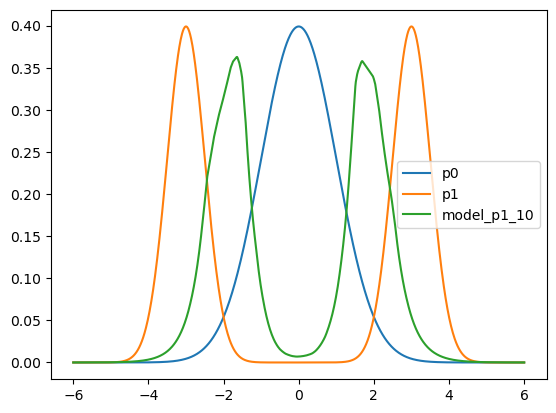

T:  9
Time:  10 iteration:  0 loss:  2.810255527496338 acc:  0.5 kl_div:  tensor(-9.0843, device='cuda:0') mse:  tensor(0.8439, device='cuda:0') js_div:  [0.00523442]
Time:  10 iteration:  100 loss:  2.1679463386535645 acc:  0.49055 kl_div:  tensor(12734.5176, device='cuda:0') mse:  tensor(0.4825, device='cuda:0') js_div:  [0.00773831]
Time:  10 iteration:  200 loss:  2.139859676361084 acc:  0.4978 kl_div:  tensor(190.6717, device='cuda:0') mse:  tensor(0.0010, device='cuda:0') js_div:  [0.00145659]
Time:  10 iteration:  300 loss:  2.1185548305511475 acc:  0.50165 kl_div:  tensor(37.1540, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00070339]
Time:  10 iteration:  400 loss:  2.100933074951172 acc:  0.50385 kl_div:  tensor(16.6263, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00055255]
Time:  10 iteration:  500 loss:  2.0890893936157227 acc:  0.5076 kl_div:  tensor(-13.9997, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00

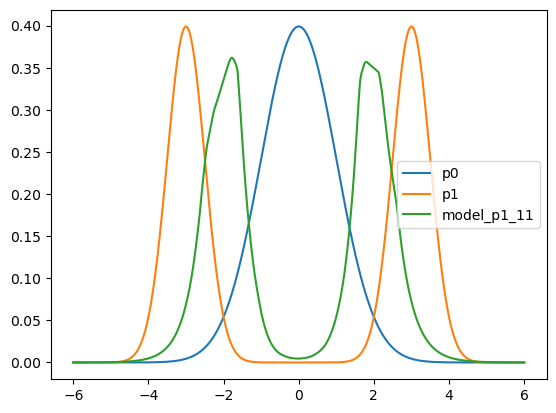

T:  10
Time:  11 iteration:  0 loss:  2.7716333866119385 acc:  0.5 kl_div:  tensor(-9.0852, device='cuda:0') mse:  tensor(0.8584, device='cuda:0') js_div:  [0.00618937]
Time:  11 iteration:  100 loss:  2.1796875 acc:  0.4947 kl_div:  tensor(13061.0762, device='cuda:0') mse:  tensor(0.5042, device='cuda:0') js_div:  [0.01098485]
Time:  11 iteration:  200 loss:  2.1501402854919434 acc:  0.4969 kl_div:  tensor(151.1838, device='cuda:0') mse:  tensor(0.0007, device='cuda:0') js_div:  [0.00091803]
Time:  11 iteration:  300 loss:  2.1230411529541016 acc:  0.50075 kl_div:  tensor(33.1358, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00061828]
Time:  11 iteration:  400 loss:  2.116201400756836 acc:  0.5043 kl_div:  tensor(13.3125, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00055914]
Time:  11 iteration:  500 loss:  2.094730854034424 acc:  0.50625 kl_div:  tensor(-4.7736, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00040837]
T

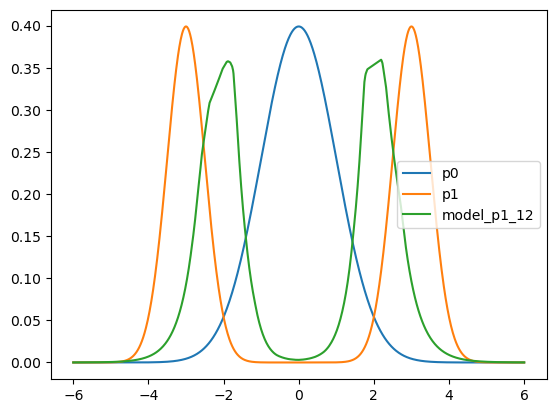

T:  11
Time:  12 iteration:  0 loss:  2.9281468391418457 acc:  0.5 kl_div:  tensor(-9.2708, device='cuda:0') mse:  tensor(1.1778, device='cuda:0') js_div:  [0.00266207]
Time:  12 iteration:  100 loss:  2.1874608993530273 acc:  0.49145 kl_div:  tensor(17018.0312, device='cuda:0') mse:  tensor(0.7392, device='cuda:0') js_div:  [0.01282145]
Time:  12 iteration:  200 loss:  2.171966552734375 acc:  0.49735 kl_div:  tensor(153.2296, device='cuda:0') mse:  tensor(0.0008, device='cuda:0') js_div:  [0.00109099]
Time:  12 iteration:  300 loss:  2.1534509658813477 acc:  0.4979 kl_div:  tensor(47.1899, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00062665]
Time:  12 iteration:  400 loss:  2.127194881439209 acc:  0.5069 kl_div:  tensor(31.5927, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00062043]
Time:  12 iteration:  500 loss:  2.104091167449951 acc:  0.5074 kl_div:  tensor(5.7438, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.0005

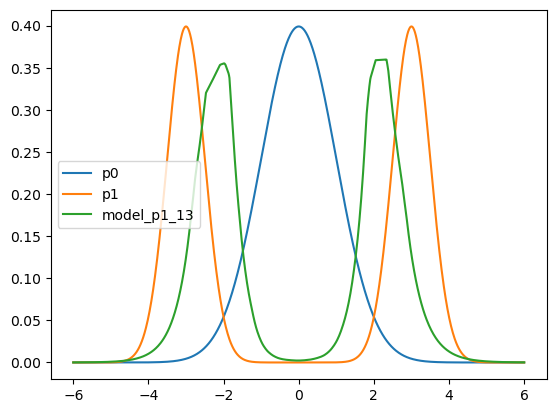

T:  12
Time:  13 iteration:  0 loss:  2.6218760013580322 acc:  0.5 kl_div:  tensor(-8.9184, device='cuda:0') mse:  tensor(0.5743, device='cuda:0') js_div:  [0.00185577]
Time:  13 iteration:  100 loss:  2.181560754776001 acc:  0.4936 kl_div:  tensor(9439.9199, device='cuda:0') mse:  tensor(0.2911, device='cuda:0') js_div:  [0.00935187]
Time:  13 iteration:  200 loss:  2.160759687423706 acc:  0.49495 kl_div:  tensor(48.0299, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00079035]
Time:  13 iteration:  300 loss:  2.131840705871582 acc:  0.5006 kl_div:  tensor(42.1312, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00079189]
Time:  13 iteration:  400 loss:  2.113600730895996 acc:  0.50645 kl_div:  tensor(27.0722, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00076592]
Time:  13 iteration:  500 loss:  2.085484027862549 acc:  0.50905 kl_div:  tensor(-5.6014, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.000601

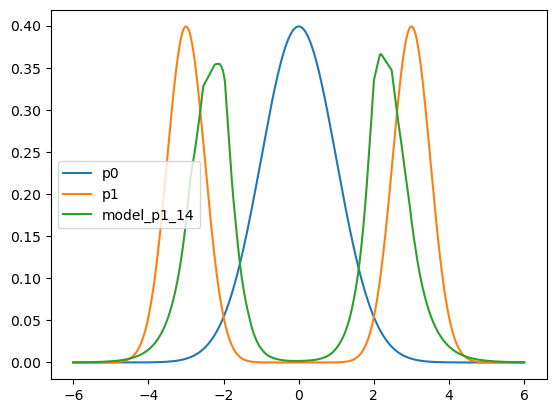

T:  13
Time:  14 iteration:  0 loss:  2.621838092803955 acc:  0.5 kl_div:  tensor(-8.9136, device='cuda:0') mse:  tensor(0.5569, device='cuda:0') js_div:  [0.00053835]
Time:  14 iteration:  100 loss:  2.1689772605895996 acc:  0.4958 kl_div:  tensor(9096.0391, device='cuda:0') mse:  tensor(0.2734, device='cuda:0') js_div:  [0.00411599]
Time:  14 iteration:  200 loss:  2.1549174785614014 acc:  0.499 kl_div:  tensor(56.4581, device='cuda:0') mse:  tensor(0.0006, device='cuda:0') js_div:  [0.00128463]
Time:  14 iteration:  300 loss:  2.1182494163513184 acc:  0.50835 kl_div:  tensor(28.5011, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00117385]
Time:  14 iteration:  400 loss:  2.08894681930542 acc:  0.5142 kl_div:  tensor(-15.1608, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00069197]
Time:  14 iteration:  500 loss:  2.071868896484375 acc:  0.5133 kl_div:  tensor(8.4555, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00043274

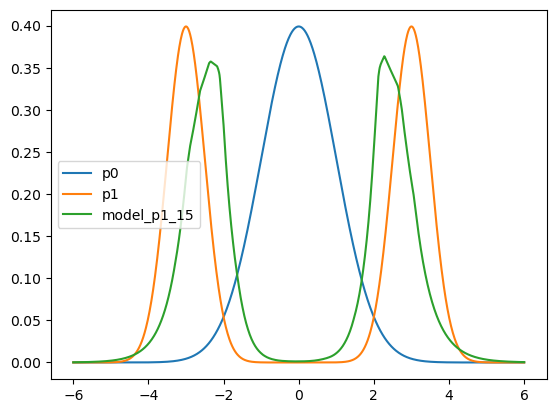

T:  14
Time:  15 iteration:  0 loss:  2.5724332332611084 acc:  0.5 kl_div:  tensor(-8.8806, device='cuda:0') mse:  tensor(0.5211, device='cuda:0') js_div:  [0.00049136]
Time:  15 iteration:  100 loss:  2.18477463722229 acc:  0.4922 kl_div:  tensor(8382.7705, device='cuda:0') mse:  tensor(0.2423, device='cuda:0') js_div:  [0.00357741]
Time:  15 iteration:  200 loss:  2.1404647827148438 acc:  0.4981 kl_div:  tensor(47.4911, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00101196]
Time:  15 iteration:  300 loss:  2.1175637245178223 acc:  0.506 kl_div:  tensor(27.1004, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00118632]
Time:  15 iteration:  400 loss:  2.0951485633850098 acc:  0.51035 kl_div:  tensor(6.3684, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00084372]
Time:  15 iteration:  500 loss:  2.0746517181396484 acc:  0.51395 kl_div:  tensor(-18.7677, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00055

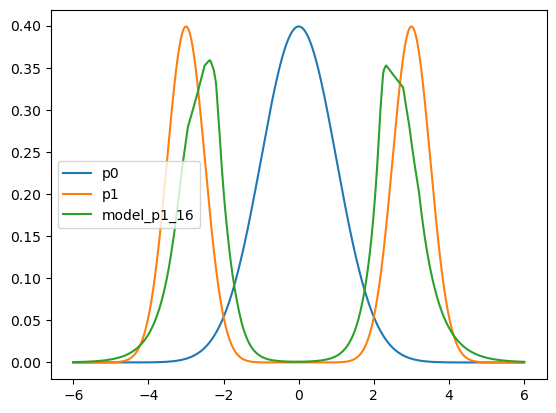

T:  15
Time:  16 iteration:  0 loss:  2.751028537750244 acc:  0.5 kl_div:  tensor(-9.0892, device='cuda:0') mse:  tensor(0.8017, device='cuda:0') js_div:  [0.00135645]
Time:  16 iteration:  100 loss:  2.201117992401123 acc:  0.49475 kl_div:  tensor(12104.0352, device='cuda:0') mse:  tensor(0.4392, device='cuda:0') js_div:  [0.00855572]
Time:  16 iteration:  200 loss:  2.1620211601257324 acc:  0.4986 kl_div:  tensor(42.5275, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00061217]
Time:  16 iteration:  300 loss:  2.1578965187072754 acc:  0.50065 kl_div:  tensor(47.8270, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00091631]
Time:  16 iteration:  400 loss:  2.113544464111328 acc:  0.50805 kl_div:  tensor(14.0906, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00104622]
Time:  16 iteration:  500 loss:  2.0830111503601074 acc:  0.51155 kl_div:  tensor(-10.4833, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.0

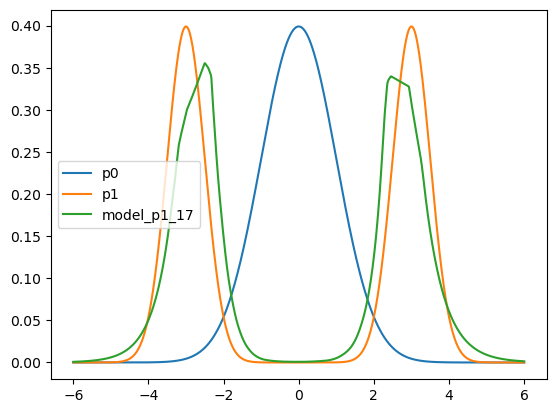

T:  16
Time:  17 iteration:  0 loss:  2.764936923980713 acc:  0.5 kl_div:  tensor(-9.2025, device='cuda:0') mse:  tensor(1.0234, device='cuda:0') js_div:  [0.0024525]
Time:  17 iteration:  100 loss:  2.178691864013672 acc:  0.4929 kl_div:  tensor(14874.3213, device='cuda:0') mse:  tensor(0.6120, device='cuda:0') js_div:  [0.00734894]
Time:  17 iteration:  200 loss:  2.148261308670044 acc:  0.49895 kl_div:  tensor(17.8914, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.0010153]
Time:  17 iteration:  300 loss:  2.108067512512207 acc:  0.50355 kl_div:  tensor(12.0738, device='cuda:0') mse:  tensor(0.0006, device='cuda:0') js_div:  [0.00134177]
Time:  17 iteration:  400 loss:  2.0849180221557617 acc:  0.51285 kl_div:  tensor(-1.9880, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.0011301]
Time:  17 iteration:  500 loss:  2.0584797859191895 acc:  0.5176 kl_div:  tensor(-36.4945, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.000591

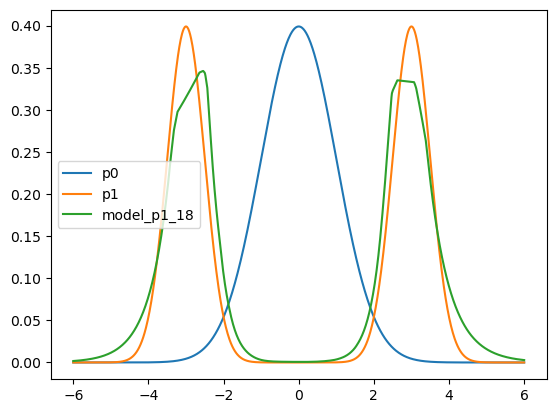

T:  17
Time:  18 iteration:  0 loss:  2.9600939750671387 acc:  0.5 kl_div:  tensor(-9.4376, device='cuda:0') mse:  tensor(1.5817, device='cuda:0') js_div:  [0.00026007]
Time:  18 iteration:  100 loss:  2.1880147457122803 acc:  0.48975 kl_div:  tensor(20690.3945, device='cuda:0') mse:  tensor(1.0260, device='cuda:0') js_div:  [0.0059243]
Time:  18 iteration:  200 loss:  2.13102650642395 acc:  0.497 kl_div:  tensor(22.7714, device='cuda:0') mse:  tensor(0.0006, device='cuda:0') js_div:  [0.00107732]
Time:  18 iteration:  300 loss:  2.108931541442871 acc:  0.50435 kl_div:  tensor(3.4601, device='cuda:0') mse:  tensor(0.0006, device='cuda:0') js_div:  [0.0012268]
Time:  18 iteration:  400 loss:  2.070495128631592 acc:  0.50865 kl_div:  tensor(-15.3319, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00110715]
Time:  18 iteration:  500 loss:  2.061357259750366 acc:  0.51555 kl_div:  tensor(-28.0932, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.000633

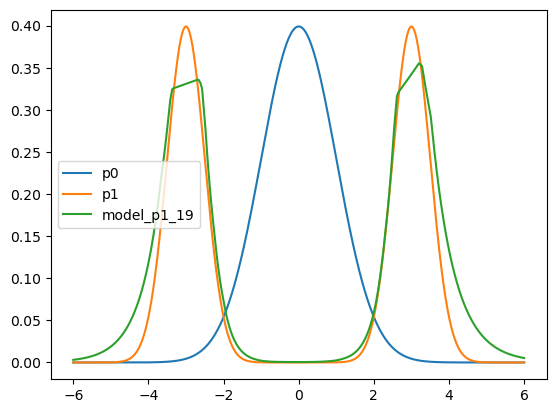

T:  18
Time:  19 iteration:  0 loss:  2.915470600128174 acc:  0.5 kl_div:  tensor(-9.4699, device='cuda:0') mse:  tensor(1.8463, device='cuda:0') js_div:  [0.00592384]
Time:  19 iteration:  100 loss:  2.198486804962158 acc:  0.49495 kl_div:  tensor(22350.1094, device='cuda:0') mse:  tensor(1.2369, device='cuda:0') js_div:  [0.0115793]
Time:  19 iteration:  200 loss:  2.1524736881256104 acc:  0.4907 kl_div:  tensor(12.7771, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00062973]
Time:  19 iteration:  300 loss:  2.130972385406494 acc:  0.49255 kl_div:  tensor(6.2461, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00078604]
Time:  19 iteration:  400 loss:  2.103785514831543 acc:  0.49835 kl_div:  tensor(7.7940, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00084133]
Time:  19 iteration:  500 loss:  2.070561647415161 acc:  0.49965 kl_div:  tensor(-26.8907, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.000592

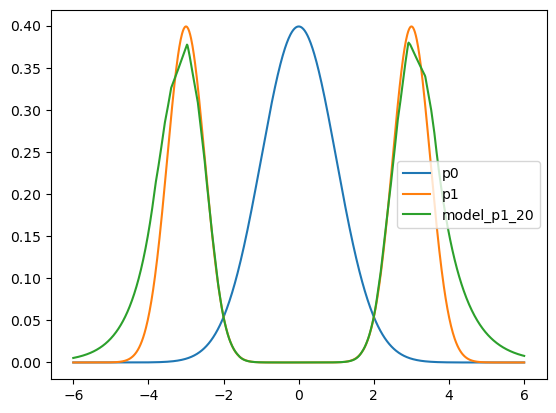

T:  19


In [13]:
model = train(u,30000,lr=1e-4,exponential=True)

## NCE with exponential loss and NGD

Time:  0 iteration:  0 loss:  2.9549832344055176 acc:  0.5 kl_div:  tensor(-9.3971, device='cuda:0') mse:  tensor(1.4765, device='cuda:0') js_div:  [0.00100006]
Time:  0 iteration:  100 loss:  2.1039652824401855 acc:  0.5 kl_div:  tensor(14511.6611, device='cuda:0') mse:  tensor(0.7102, device='cuda:0') js_div:  [0.0114919]
Time:  0 iteration:  200 loss:  1.9994138479232788 acc:  0.52335 kl_div:  tensor(1779.0723, device='cuda:0') mse:  tensor(0.0204, device='cuda:0') js_div:  [0.00731257]
Time:  0 iteration:  300 loss:  1.994511604309082 acc:  0.53965 kl_div:  tensor(-34.1070, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00078854]
Time:  0 iteration:  400 loss:  1.9917566776275635 acc:  0.5418 kl_div:  tensor(-6.8949, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00038759]
Time:  0 iteration:  500 loss:  1.9916094541549683 acc:  0.5392 kl_div:  tensor(-11.2498, device='cuda:0') mse:  tensor(1.0864e-05, device='cuda:0') js_div:  [2.1818894e-05

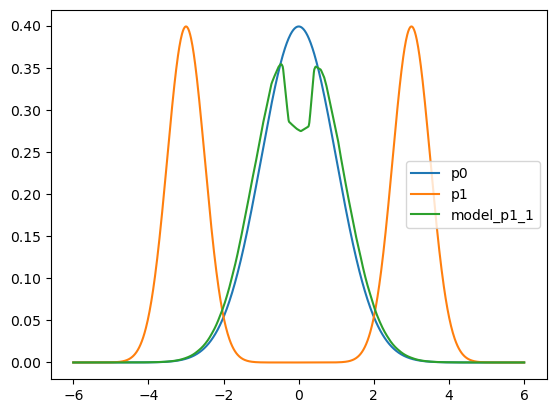

T:  0
Time:  1 iteration:  0 loss:  2.684713840484619 acc:  0.5 kl_div:  tensor(-9.0812, device='cuda:0') mse:  tensor(0.7735, device='cuda:0') js_div:  [0.0001043]
Time:  1 iteration:  100 loss:  2.058844566345215 acc:  0.5 kl_div:  tensor(9745.4551, device='cuda:0') mse:  tensor(0.3350, device='cuda:0') js_div:  [0.01167621]
Time:  1 iteration:  200 loss:  2.0106658935546875 acc:  0.4915 kl_div:  tensor(874.9510, device='cuda:0') mse:  tensor(0.0061, device='cuda:0') js_div:  [0.00110493]
Time:  1 iteration:  300 loss:  1.998194694519043 acc:  0.53615 kl_div:  tensor(-26.6100, device='cuda:0') mse:  tensor(0.0007, device='cuda:0') js_div:  [0.00140118]
Time:  1 iteration:  400 loss:  1.9925024509429932 acc:  0.5401 kl_div:  tensor(-56.6625, device='cuda:0') mse:  tensor(0.0007, device='cuda:0') js_div:  [0.00126423]
Time:  1 iteration:  500 loss:  1.990990400314331 acc:  0.5402 kl_div:  tensor(-21.7639, device='cuda:0') mse:  tensor(5.5400e-05, device='cuda:0') js_div:  [9.475101e-05

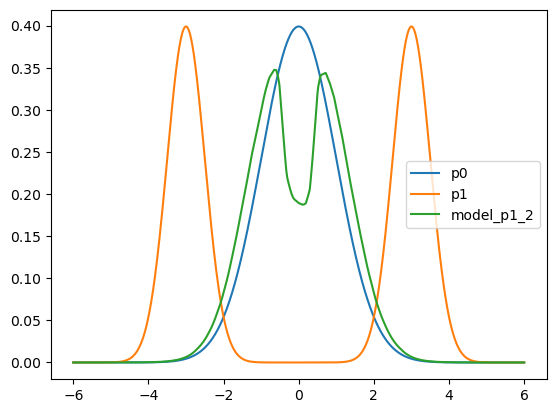

T:  1
Time:  2 iteration:  0 loss:  2.6889028549194336 acc:  0.5 kl_div:  tensor(-9.0822, device='cuda:0') mse:  tensor(0.7752, device='cuda:0') js_div:  [0.00011143]
Time:  2 iteration:  100 loss:  2.0825302600860596 acc:  0.49615 kl_div:  tensor(10006.0039, device='cuda:0') mse:  tensor(0.3475, device='cuda:0') js_div:  [0.01069455]
Time:  2 iteration:  200 loss:  2.0290870666503906 acc:  0.4879 kl_div:  tensor(919.6275, device='cuda:0') mse:  tensor(0.0070, device='cuda:0') js_div:  [0.00183044]
Time:  2 iteration:  300 loss:  2.012204647064209 acc:  0.5047 kl_div:  tensor(-28.1610, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00128391]
Time:  2 iteration:  400 loss:  1.9986404180526733 acc:  0.53015 kl_div:  tensor(-48.1072, device='cuda:0') mse:  tensor(0.0006, device='cuda:0') js_div:  [0.00141878]
Time:  2 iteration:  500 loss:  1.9928052425384521 acc:  0.53995 kl_div:  tensor(-68.9781, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.0008

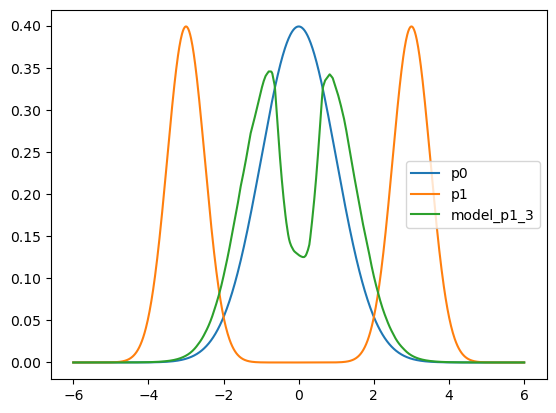

T:  2
Time:  3 iteration:  0 loss:  2.581669330596924 acc:  0.5 kl_div:  tensor(-8.9263, device='cuda:0') mse:  tensor(0.5781, device='cuda:0') js_div:  [0.00129616]
Time:  3 iteration:  100 loss:  2.0605549812316895 acc:  0.4864 kl_div:  tensor(9821.7422, device='cuda:0') mse:  tensor(0.2950, device='cuda:0') js_div:  [0.0129021]
Time:  3 iteration:  200 loss:  2.0378365516662598 acc:  0.48985 kl_div:  tensor(94.4676, device='cuda:0') mse:  tensor(0.0008, device='cuda:0') js_div:  [0.00173294]
Time:  3 iteration:  300 loss:  2.0148866176605225 acc:  0.4966 kl_div:  tensor(-28.4649, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00139143]
Time:  3 iteration:  400 loss:  1.9998130798339844 acc:  0.5245 kl_div:  tensor(-64.1223, device='cuda:0') mse:  tensor(0.0008, device='cuda:0') js_div:  [0.00181071]
Time:  3 iteration:  500 loss:  1.992889165878296 acc:  0.53915 kl_div:  tensor(-85.2264, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00102251]

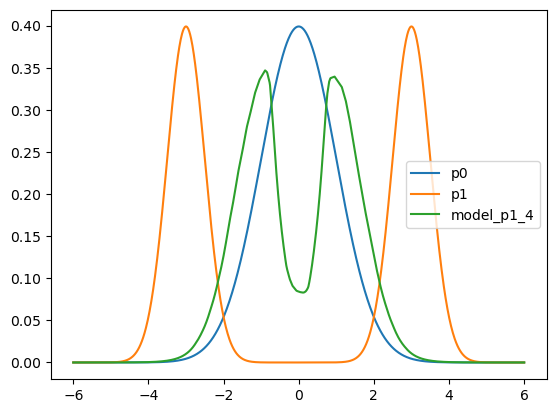

T:  3
Time:  4 iteration:  0 loss:  2.8773908615112305 acc:  0.5 kl_div:  tensor(-9.2207, device='cuda:0') mse:  tensor(1.0922, device='cuda:0') js_div:  [0.00427934]
Time:  4 iteration:  100 loss:  2.1088619232177734 acc:  0.4818 kl_div:  tensor(15042.1396, device='cuda:0') mse:  tensor(0.6357, device='cuda:0') js_div:  [0.02224206]
Time:  4 iteration:  200 loss:  2.061413049697876 acc:  0.4911 kl_div:  tensor(686.1261, device='cuda:0') mse:  tensor(0.0055, device='cuda:0') js_div:  [0.00219154]
Time:  4 iteration:  300 loss:  2.0335006713867188 acc:  0.49505 kl_div:  tensor(-20.0208, device='cuda:0') mse:  tensor(0.0006, device='cuda:0') js_div:  [0.00152069]
Time:  4 iteration:  400 loss:  2.0095267295837402 acc:  0.5064 kl_div:  tensor(-75.5242, device='cuda:0') mse:  tensor(0.0007, device='cuda:0') js_div:  [0.00163471]
Time:  4 iteration:  500 loss:  1.9956557750701904 acc:  0.53575 kl_div:  tensor(-98.2048, device='cuda:0') mse:  tensor(0.0008, device='cuda:0') js_div:  [0.00173

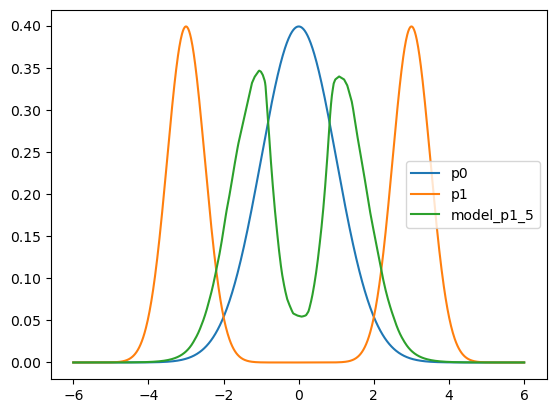

T:  4
Time:  5 iteration:  0 loss:  3.029301881790161 acc:  0.5 kl_div:  tensor(-9.3169, device='cuda:0') mse:  tensor(1.2427, device='cuda:0') js_div:  [0.0002752]
Time:  5 iteration:  100 loss:  2.1376090049743652 acc:  0.48245 kl_div:  tensor(16534.4023, device='cuda:0') mse:  tensor(0.7219, device='cuda:0') js_div:  [0.0162559]
Time:  5 iteration:  200 loss:  2.0776872634887695 acc:  0.4921 kl_div:  tensor(790.4917, device='cuda:0') mse:  tensor(0.0072, device='cuda:0') js_div:  [0.00283755]
Time:  5 iteration:  300 loss:  2.045773983001709 acc:  0.49865 kl_div:  tensor(24.6931, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00151756]
Time:  5 iteration:  400 loss:  2.0213794708251953 acc:  0.5034 kl_div:  tensor(-90.1281, device='cuda:0') mse:  tensor(0.0006, device='cuda:0') js_div:  [0.00143575]
Time:  5 iteration:  500 loss:  1.9996044635772705 acc:  0.52695 kl_div:  tensor(-104.7172, device='cuda:0') mse:  tensor(0.0007, device='cuda:0') js_div:  [0.0015672

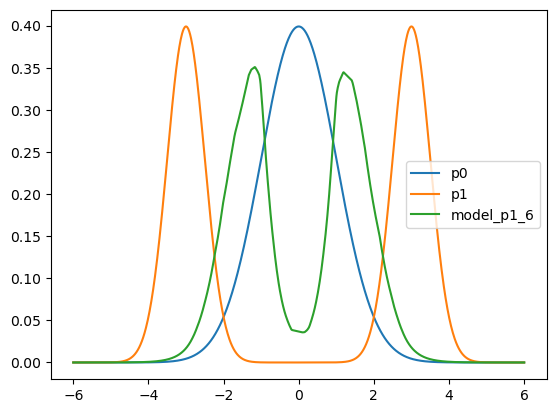

T:  5
Time:  6 iteration:  0 loss:  2.9431614875793457 acc:  0.5 kl_div:  tensor(-9.2556, device='cuda:0') mse:  tensor(1.1336, device='cuda:0') js_div:  [0.00217846]
Time:  6 iteration:  100 loss:  2.1292643547058105 acc:  0.48575 kl_div:  tensor(17358.5742, device='cuda:0') mse:  tensor(0.7277, device='cuda:0') js_div:  [0.01632091]
Time:  6 iteration:  200 loss:  2.0878162384033203 acc:  0.4956 kl_div:  tensor(224.9567, device='cuda:0') mse:  tensor(0.0022, device='cuda:0') js_div:  [0.00431023]
Time:  6 iteration:  300 loss:  2.0534963607788086 acc:  0.50125 kl_div:  tensor(-18.1744, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00139683]
Time:  6 iteration:  400 loss:  2.023275375366211 acc:  0.5084 kl_div:  tensor(-66.4972, device='cuda:0') mse:  tensor(0.0006, device='cuda:0') js_div:  [0.00152743]
Time:  6 iteration:  500 loss:  2.0014495849609375 acc:  0.52975 kl_div:  tensor(-115.7442, device='cuda:0') mse:  tensor(0.0009, device='cuda:0') js_div:  [0.001

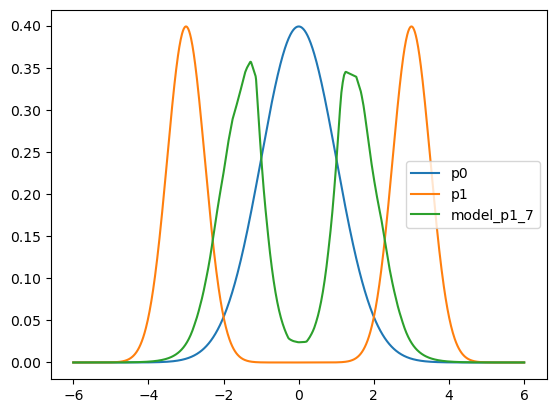

T:  6
Time:  7 iteration:  0 loss:  2.9640913009643555 acc:  0.5 kl_div:  tensor(-9.2719, device='cuda:0') mse:  tensor(1.1435, device='cuda:0') js_div:  [0.00068842]
Time:  7 iteration:  100 loss:  2.1573030948638916 acc:  0.49055 kl_div:  tensor(15961.1162, device='cuda:0') mse:  tensor(0.6778, device='cuda:0') js_div:  [0.01611021]
Time:  7 iteration:  200 loss:  2.107347249984741 acc:  0.49235 kl_div:  tensor(621.1718, device='cuda:0') mse:  tensor(0.0050, device='cuda:0') js_div:  [0.00307441]
Time:  7 iteration:  300 loss:  2.0676865577697754 acc:  0.50085 kl_div:  tensor(5.0628, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00143518]
Time:  7 iteration:  400 loss:  2.043450355529785 acc:  0.50615 kl_div:  tensor(-74.2983, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00121499]
Time:  7 iteration:  500 loss:  2.0183873176574707 acc:  0.51615 kl_div:  tensor(-73.6173, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00119

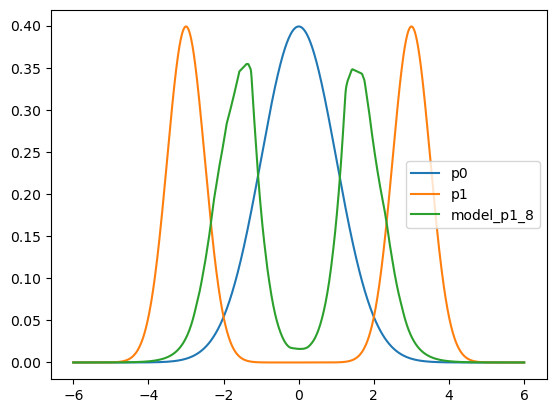

T:  7
Time:  8 iteration:  0 loss:  3.295768976211548 acc:  0.5 kl_div:  tensor(-9.5412, device='cuda:0') mse:  tensor(2.0276, device='cuda:0') js_div:  [0.00275058]
Time:  8 iteration:  100 loss:  2.1939332485198975 acc:  0.4943 kl_div:  tensor(23215.0156, device='cuda:0') mse:  tensor(1.3136, device='cuda:0') js_div:  [0.02197271]
Time:  8 iteration:  200 loss:  2.120128631591797 acc:  0.49405 kl_div:  tensor(1183.2883, device='cuda:0') mse:  tensor(0.0127, device='cuda:0') js_div:  [0.00470785]
Time:  8 iteration:  300 loss:  2.089951992034912 acc:  0.5031 kl_div:  tensor(8.3830, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00150611]
Time:  8 iteration:  400 loss:  2.0613014698028564 acc:  0.5028 kl_div:  tensor(-37.6219, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.0007667]
Time:  8 iteration:  500 loss:  2.0345635414123535 acc:  0.50615 kl_div:  tensor(-37.4014, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00096861]

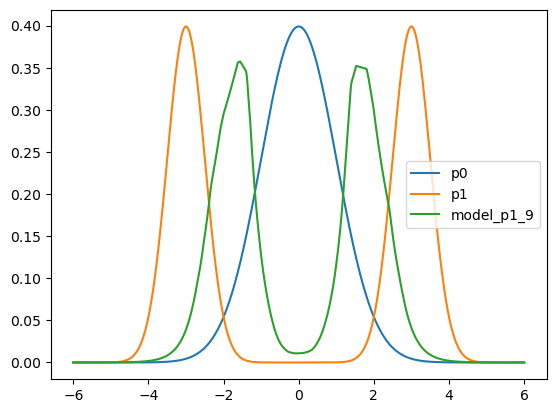

T:  8
Time:  9 iteration:  0 loss:  2.7513885498046875 acc:  0.5 kl_div:  tensor(-9.0447, device='cuda:0') mse:  tensor(0.7495, device='cuda:0') js_div:  [0.00273881]
Time:  9 iteration:  100 loss:  2.170090675354004 acc:  0.4865 kl_div:  tensor(12306.6035, device='cuda:0') mse:  tensor(0.4270, device='cuda:0') js_div:  [0.01085538]
Time:  9 iteration:  200 loss:  2.130206823348999 acc:  0.49685 kl_div:  tensor(106.1552, device='cuda:0') mse:  tensor(0.0018, device='cuda:0') js_div:  [0.00429428]
Time:  9 iteration:  300 loss:  2.0941638946533203 acc:  0.50035 kl_div:  tensor(24.9346, device='cuda:0') mse:  tensor(0.0005, device='cuda:0') js_div:  [0.00137704]
Time:  9 iteration:  400 loss:  2.0657691955566406 acc:  0.50715 kl_div:  tensor(-13.9701, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00076549]
Time:  9 iteration:  500 loss:  2.0420985221862793 acc:  0.508 kl_div:  tensor(-47.0414, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.0008494

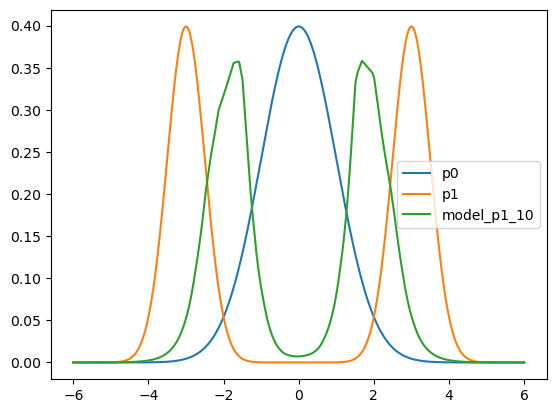

T:  9
Time:  10 iteration:  0 loss:  2.8416922092437744 acc:  0.5 kl_div:  tensor(-9.1248, device='cuda:0') mse:  tensor(0.8552, device='cuda:0') js_div:  [0.00093422]
Time:  10 iteration:  100 loss:  2.1879401206970215 acc:  0.48255 kl_div:  tensor(13410.4551, device='cuda:0') mse:  tensor(0.4906, device='cuda:0') js_div:  [0.01046423]
Time:  10 iteration:  200 loss:  2.124997138977051 acc:  0.50105 kl_div:  tensor(225.5889, device='cuda:0') mse:  tensor(0.0032, device='cuda:0') js_div:  [0.00638313]
Time:  10 iteration:  300 loss:  2.099813938140869 acc:  0.50325 kl_div:  tensor(31.3165, device='cuda:0') mse:  tensor(0.0006, device='cuda:0') js_div:  [0.00188804]
Time:  10 iteration:  400 loss:  2.069673776626587 acc:  0.5051 kl_div:  tensor(-20.9136, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00071574]
Time:  10 iteration:  500 loss:  2.0404696464538574 acc:  0.50655 kl_div:  tensor(-86.1618, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.

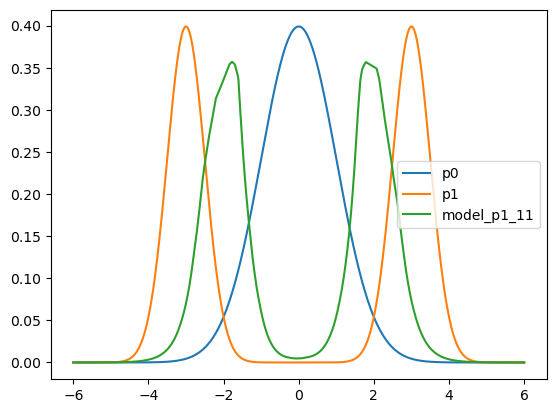

T:  10
Time:  11 iteration:  0 loss:  2.7662222385406494 acc:  0.5 kl_div:  tensor(-9.0914, device='cuda:0') mse:  tensor(0.8069, device='cuda:0') js_div:  [0.00147901]
Time:  11 iteration:  100 loss:  2.177988052368164 acc:  0.4898 kl_div:  tensor(13091.2764, device='cuda:0') mse:  tensor(0.4736, device='cuda:0') js_div:  [0.00976745]
Time:  11 iteration:  200 loss:  2.1349635124206543 acc:  0.5028 kl_div:  tensor(124.8924, device='cuda:0') mse:  tensor(0.0021, device='cuda:0') js_div:  [0.00508053]
Time:  11 iteration:  300 loss:  2.10408353805542 acc:  0.5064 kl_div:  tensor(10.8329, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00094597]
Time:  11 iteration:  400 loss:  2.082624912261963 acc:  0.50655 kl_div:  tensor(-43.0039, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00051299]
Time:  11 iteration:  500 loss:  2.057671546936035 acc:  0.5085 kl_div:  tensor(-16.0875, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.0005

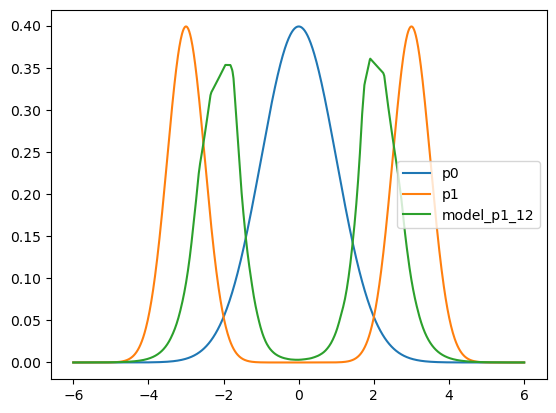

T:  11
Time:  12 iteration:  0 loss:  2.84291672706604 acc:  0.5 kl_div:  tensor(-9.1158, device='cuda:0') mse:  tensor(0.9158, device='cuda:0') js_div:  [0.00641591]
Time:  12 iteration:  100 loss:  2.186776638031006 acc:  0.4914 kl_div:  tensor(13979.9082, device='cuda:0') mse:  tensor(0.5561, device='cuda:0') js_div:  [0.01462318]
Time:  12 iteration:  200 loss:  2.131960391998291 acc:  0.49765 kl_div:  tensor(169.1754, device='cuda:0') mse:  tensor(0.0019, device='cuda:0') js_div:  [0.0037523]
Time:  12 iteration:  300 loss:  2.09858775138855 acc:  0.5073 kl_div:  tensor(44.4729, device='cuda:0') mse:  tensor(0.0006, device='cuda:0') js_div:  [0.00178794]
Time:  12 iteration:  400 loss:  2.0701732635498047 acc:  0.50995 kl_div:  tensor(-53.0911, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00075257]
Time:  12 iteration:  500 loss:  2.04116153717041 acc:  0.50995 kl_div:  tensor(-26.5876, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.000823

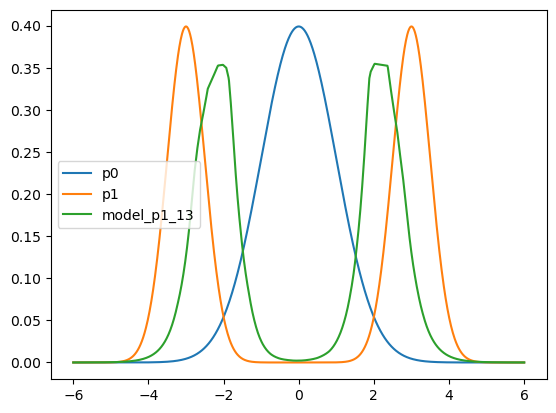

T:  12
Time:  13 iteration:  0 loss:  2.746305465698242 acc:  0.5 kl_div:  tensor(-9.0374, device='cuda:0') mse:  tensor(0.7369, device='cuda:0') js_div:  [0.00257556]
Time:  13 iteration:  100 loss:  2.170858860015869 acc:  0.4958 kl_div:  tensor(11772.5889, device='cuda:0') mse:  tensor(0.4154, device='cuda:0') js_div:  [0.00665671]
Time:  13 iteration:  200 loss:  2.1272382736206055 acc:  0.5053 kl_div:  tensor(146.0737, device='cuda:0') mse:  tensor(0.0019, device='cuda:0') js_div:  [0.00436152]
Time:  13 iteration:  300 loss:  2.0950546264648438 acc:  0.5093 kl_div:  tensor(8.6489, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00141465]
Time:  13 iteration:  400 loss:  2.070368766784668 acc:  0.51505 kl_div:  tensor(-6.3346, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00061542]
Time:  13 iteration:  500 loss:  2.0481045246124268 acc:  0.5155 kl_div:  tensor(-65.0515, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.0004

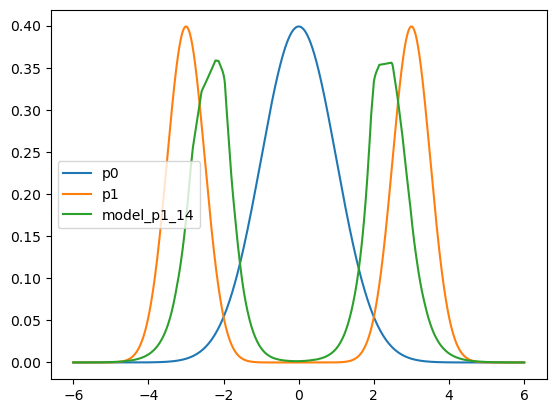

T:  13
Time:  14 iteration:  0 loss:  3.0406088829040527 acc:  0.5 kl_div:  tensor(-9.3417, device='cuda:0') mse:  tensor(1.3558, device='cuda:0') js_div:  [0.00261097]
Time:  14 iteration:  100 loss:  2.2083847522735596 acc:  0.4941 kl_div:  tensor(19920.2422, device='cuda:0') mse:  tensor(0.9117, device='cuda:0') js_div:  [0.01340112]
Time:  14 iteration:  200 loss:  2.1574923992156982 acc:  0.50225 kl_div:  tensor(43.2305, device='cuda:0') mse:  tensor(0.0021, device='cuda:0') js_div:  [0.00507116]
Time:  14 iteration:  300 loss:  2.1220219135284424 acc:  0.51065 kl_div:  tensor(53.5018, device='cuda:0') mse:  tensor(0.0008, device='cuda:0') js_div:  [0.00240895]
Time:  14 iteration:  400 loss:  2.1029369831085205 acc:  0.50895 kl_div:  tensor(-27.6500, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00044084]
Time:  14 iteration:  500 loss:  2.0770034790039062 acc:  0.51435 kl_div:  tensor(-2.4579, device='cuda:0') mse:  tensor(9.1317e-05, device='cuda:0') js_div

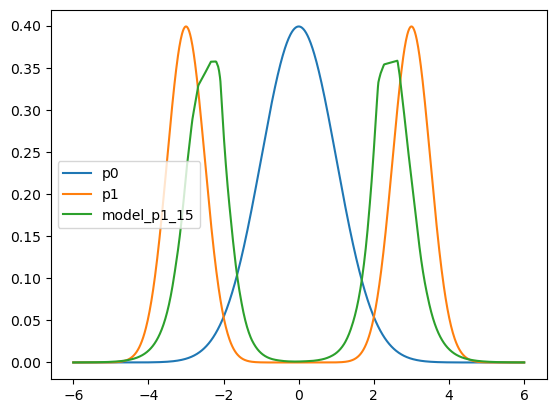

T:  14
Time:  15 iteration:  0 loss:  2.8093767166137695 acc:  0.5 kl_div:  tensor(-9.1359, device='cuda:0') mse:  tensor(0.8654, device='cuda:0') js_div:  [0.0002854]
Time:  15 iteration:  100 loss:  2.1837191581726074 acc:  0.49725 kl_div:  tensor(13418.3770, device='cuda:0') mse:  tensor(0.5011, device='cuda:0') js_div:  [0.00433991]
Time:  15 iteration:  200 loss:  2.1279382705688477 acc:  0.50795 kl_div:  tensor(86.9701, device='cuda:0') mse:  tensor(0.0018, device='cuda:0') js_div:  [0.00425454]
Time:  15 iteration:  300 loss:  2.090639591217041 acc:  0.5149 kl_div:  tensor(24.3846, device='cuda:0') mse:  tensor(0.0006, device='cuda:0') js_div:  [0.0018209]
Time:  15 iteration:  400 loss:  2.0732672214508057 acc:  0.51915 kl_div:  tensor(-46.8239, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00040646]
Time:  15 iteration:  500 loss:  2.0485897064208984 acc:  0.5193 kl_div:  tensor(-61.2826, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.0

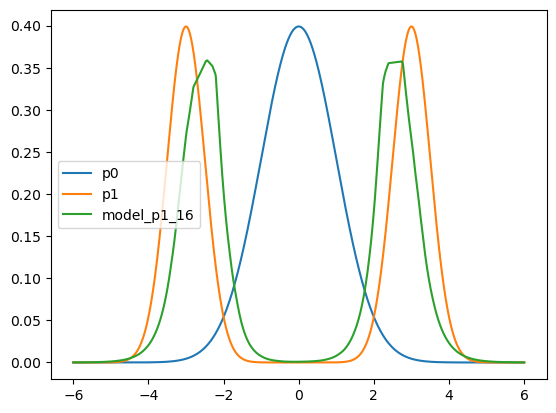

T:  15
Time:  16 iteration:  0 loss:  2.7527613639831543 acc:  0.5 kl_div:  tensor(-9.0838, device='cuda:0') mse:  tensor(0.7882, device='cuda:0') js_div:  [0.00095714]
Time:  16 iteration:  100 loss:  2.1878838539123535 acc:  0.501 kl_div:  tensor(12245.8438, device='cuda:0') mse:  tensor(0.4414, device='cuda:0') js_div:  [0.00507165]
Time:  16 iteration:  200 loss:  2.1519274711608887 acc:  0.5073 kl_div:  tensor(114.9693, device='cuda:0') mse:  tensor(0.0018, device='cuda:0') js_div:  [0.00406071]
Time:  16 iteration:  300 loss:  2.1126368045806885 acc:  0.5124 kl_div:  tensor(-10.1874, device='cuda:0') mse:  tensor(0.0009, device='cuda:0') js_div:  [0.00236689]
Time:  16 iteration:  400 loss:  2.0831432342529297 acc:  0.51555 kl_div:  tensor(-31.7983, device='cuda:0') mse:  tensor(0.0001, device='cuda:0') js_div:  [0.00034527]
Time:  16 iteration:  500 loss:  2.0741820335388184 acc:  0.51495 kl_div:  tensor(21.5064, device='cuda:0') mse:  tensor(8.3038e-05, device='cuda:0') js_div:

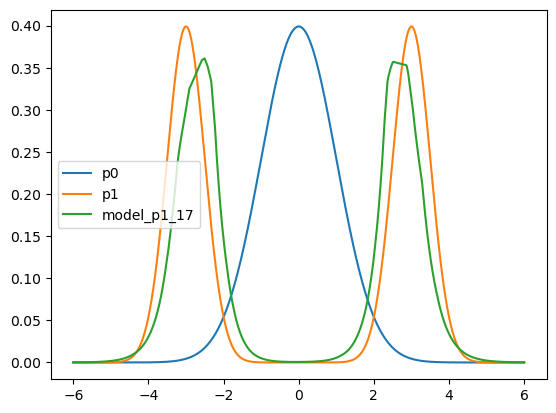

T:  16
Time:  17 iteration:  0 loss:  2.8077139854431152 acc:  0.5 kl_div:  tensor(-9.1274, device='cuda:0') mse:  tensor(0.8624, device='cuda:0') js_div:  [0.00114048]
Time:  17 iteration:  100 loss:  2.2106218338012695 acc:  0.49195 kl_div:  tensor(13024.9062, device='cuda:0') mse:  tensor(0.4876, device='cuda:0') js_div:  [0.00540115]
Time:  17 iteration:  200 loss:  2.1479196548461914 acc:  0.50105 kl_div:  tensor(74.9163, device='cuda:0') mse:  tensor(0.0014, device='cuda:0') js_div:  [0.00283398]
Time:  17 iteration:  300 loss:  2.1183738708496094 acc:  0.50825 kl_div:  tensor(38.3361, device='cuda:0') mse:  tensor(0.0011, device='cuda:0') js_div:  [0.00271618]
Time:  17 iteration:  400 loss:  2.0887465476989746 acc:  0.51215 kl_div:  tensor(18.1692, device='cuda:0') mse:  tensor(0.0004, device='cuda:0') js_div:  [0.00120001]
Time:  17 iteration:  500 loss:  2.0677976608276367 acc:  0.5194 kl_div:  tensor(-72.1272, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [

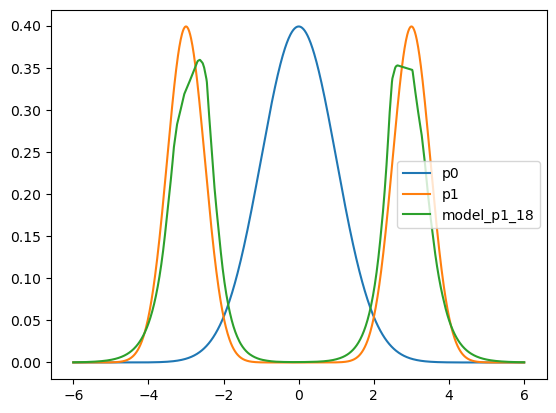

T:  17
Time:  18 iteration:  0 loss:  2.9832592010498047 acc:  0.5 kl_div:  tensor(-9.3982, device='cuda:0') mse:  tensor(1.5596, device='cuda:0') js_div:  [0.00429189]
Time:  18 iteration:  100 loss:  2.1639599800109863 acc:  0.49725 kl_div:  tensor(20875.7773, device='cuda:0') mse:  tensor(1.0538, device='cuda:0') js_div:  [0.00837336]
Time:  18 iteration:  200 loss:  2.128241539001465 acc:  0.50835 kl_div:  tensor(78.0717, device='cuda:0') mse:  tensor(0.0018, device='cuda:0') js_div:  [0.00408086]
Time:  18 iteration:  300 loss:  2.091804027557373 acc:  0.51405 kl_div:  tensor(17.6959, device='cuda:0') mse:  tensor(0.0008, device='cuda:0') js_div:  [0.00219555]
Time:  18 iteration:  400 loss:  2.0814640522003174 acc:  0.5175 kl_div:  tensor(-37.7128, device='cuda:0') mse:  tensor(0.0002, device='cuda:0') js_div:  [0.00053912]
Time:  18 iteration:  500 loss:  2.0643532276153564 acc:  0.5196 kl_div:  tensor(-47.4307, device='cuda:0') mse:  tensor(8.3848e-05, device='cuda:0') js_div: 

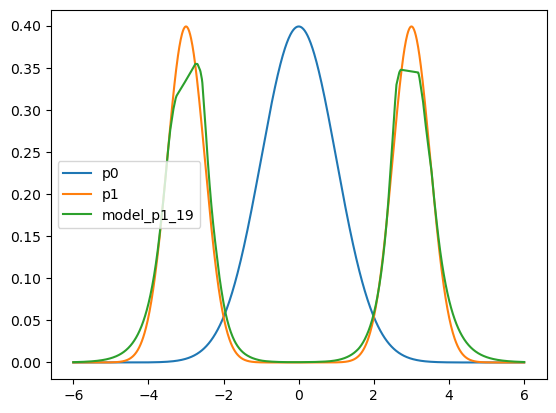

T:  18
Time:  19 iteration:  0 loss:  2.565840005874634 acc:  0.5 kl_div:  tensor(-8.8237, device='cuda:0') mse:  tensor(0.4812, device='cuda:0') js_div:  [0.00263352]
Time:  19 iteration:  100 loss:  2.1801934242248535 acc:  0.49085 kl_div:  tensor(7171.0137, device='cuda:0') mse:  tensor(0.2021, device='cuda:0') js_div:  [0.00276633]
Time:  19 iteration:  200 loss:  2.1588735580444336 acc:  0.4983 kl_div:  tensor(59.1096, device='cuda:0') mse:  tensor(0.0013, device='cuda:0') js_div:  [0.00251796]
Time:  19 iteration:  300 loss:  2.1146457195281982 acc:  0.4989 kl_div:  tensor(19.6613, device='cuda:0') mse:  tensor(0.0008, device='cuda:0') js_div:  [0.00195295]
Time:  19 iteration:  400 loss:  2.079484462738037 acc:  0.50075 kl_div:  tensor(-12.8773, device='cuda:0') mse:  tensor(0.0003, device='cuda:0') js_div:  [0.00079416]
Time:  19 iteration:  500 loss:  2.0705318450927734 acc:  0.49945 kl_div:  tensor(28.4782, device='cuda:0') mse:  tensor(5.7051e-05, device='cuda:0') js_div:  [

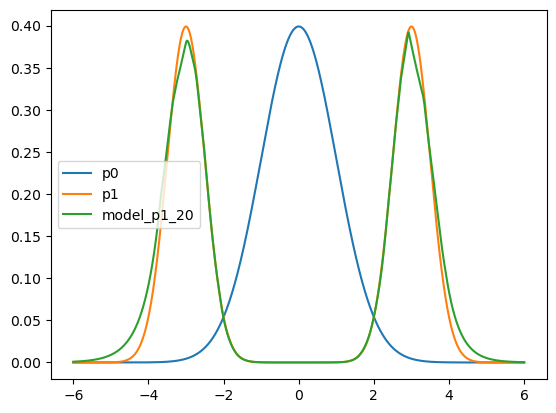

T:  19


In [13]:
model = train(u,30000,lr=1e-4,exponential=True,normalize_grad=True)